# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [1]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [2]:
# Complete this cell with your code
import numpy as np
from scipy.stats import entropy
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

c:\Users\cemuelle\AppData\Local\pypoetry\Cache\virtualenvs\301-explainable-ml-d8oFEqwf-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [3]:
# Complete this cell with your code

""" from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features
y = wine_quality.data.targets

print(wine_quality.metadata)

print(wine_quality.variables) """

# Load the dataset from the provided URL
data_url = "https://archive.ics.uci.edu/static/public/186/data.csv"
wine_data = pd.read_csv(data_url)

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [4]:
# Complete this cell with your code
print(wine_data.head())

# Total number of samples and features
num_samples = wine_data.shape[0]
num_features = wine_data.shape[1] - 1  # subtract 1 for the target column

# Number of red and white wines
num_red_wines = wine_data[wine_data["color"] == "red"].shape[0]
num_white_wines = wine_data[wine_data["color"] == "white"].shape[0]

# Number of good and bad wines (arbitrarily choosen : quality > 6 is "good", otherwise "bad")
good_wines = wine_data[wine_data["quality"] > 6].shape[0]
bad_wines = wine_data[wine_data["quality"] <= 6].shape[0]

print(f"Total number of samples: {num_samples}")
print(f"Total number of features: {num_features}")
print(f"Number of red wines: {num_red_wines}")
print(f"Number of white wines: {num_white_wines}")
print(f"Number of good wines (quality > 6): {good_wines}")
print(f"Number of bad wines (quality <= 6): {bad_wines}")

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2 

## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [5]:
# Complete this cell with your code

print("Statiscal summary of the dataset:")
wine_data.describe()

Statiscal summary of the dataset:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
print("\nStatiscal summary for red wines:")
red_wine = wine_data[wine_data["color"] == "red"]
red_wine.describe()


Statiscal summary for red wines:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
print("\nStatiscal summary for white wines:")
white_wine = wine_data[wine_data["color"] == "white"]
white_wine.describe()


Statiscal summary for white wines:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [8]:
# Compute SSMD for each feature
features = wine_data.columns[:-2]  # Exclude 'quality' and 'color'
ssmd_dict = {}

for feature in features:
    mu_red = red_wine[feature].mean()
    mu_white = white_wine[feature].mean()
    std_red = red_wine[feature].std()
    std_white = white_wine[feature].std()

    # Calculate SSMD
    ssmd = (mu_red - mu_white) / np.sqrt(std_red**2 + std_white**2)
    ssmd_dict[feature] = ssmd

# Convert the SSMD values to a DataFrame for better display
ssmd_df = pd.DataFrame(list(ssmd_dict.items()), columns=["Feature", "SSMD"])

# Display SSMD results
print("\nStrictly Standardized Mean Differences (SSMD) between Red and White Wines:")
print(ssmd_df)


Strictly Standardized Mean Differences (SSMD) between Red and White Wines:
                 Feature      SSMD
0          fixed_acidity  0.757098
1       volatile_acidity  1.214618
2            citric_acid -0.275652
3         residual_sugar -0.731826
4              chlorides  0.803525
5    free_sulfur_dioxide -0.973293
6   total_sulfur_dioxide -1.709894
7                density  0.768903
8                     pH  0.568854
9              sulphates  0.823612
10               alcohol -0.056074


#### Differences between red and white wines
- The alcool almost doesn't change between red and white wines
- pH change little
- 
- total sulfur dioxide and volatile acidity are what changes the most

Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

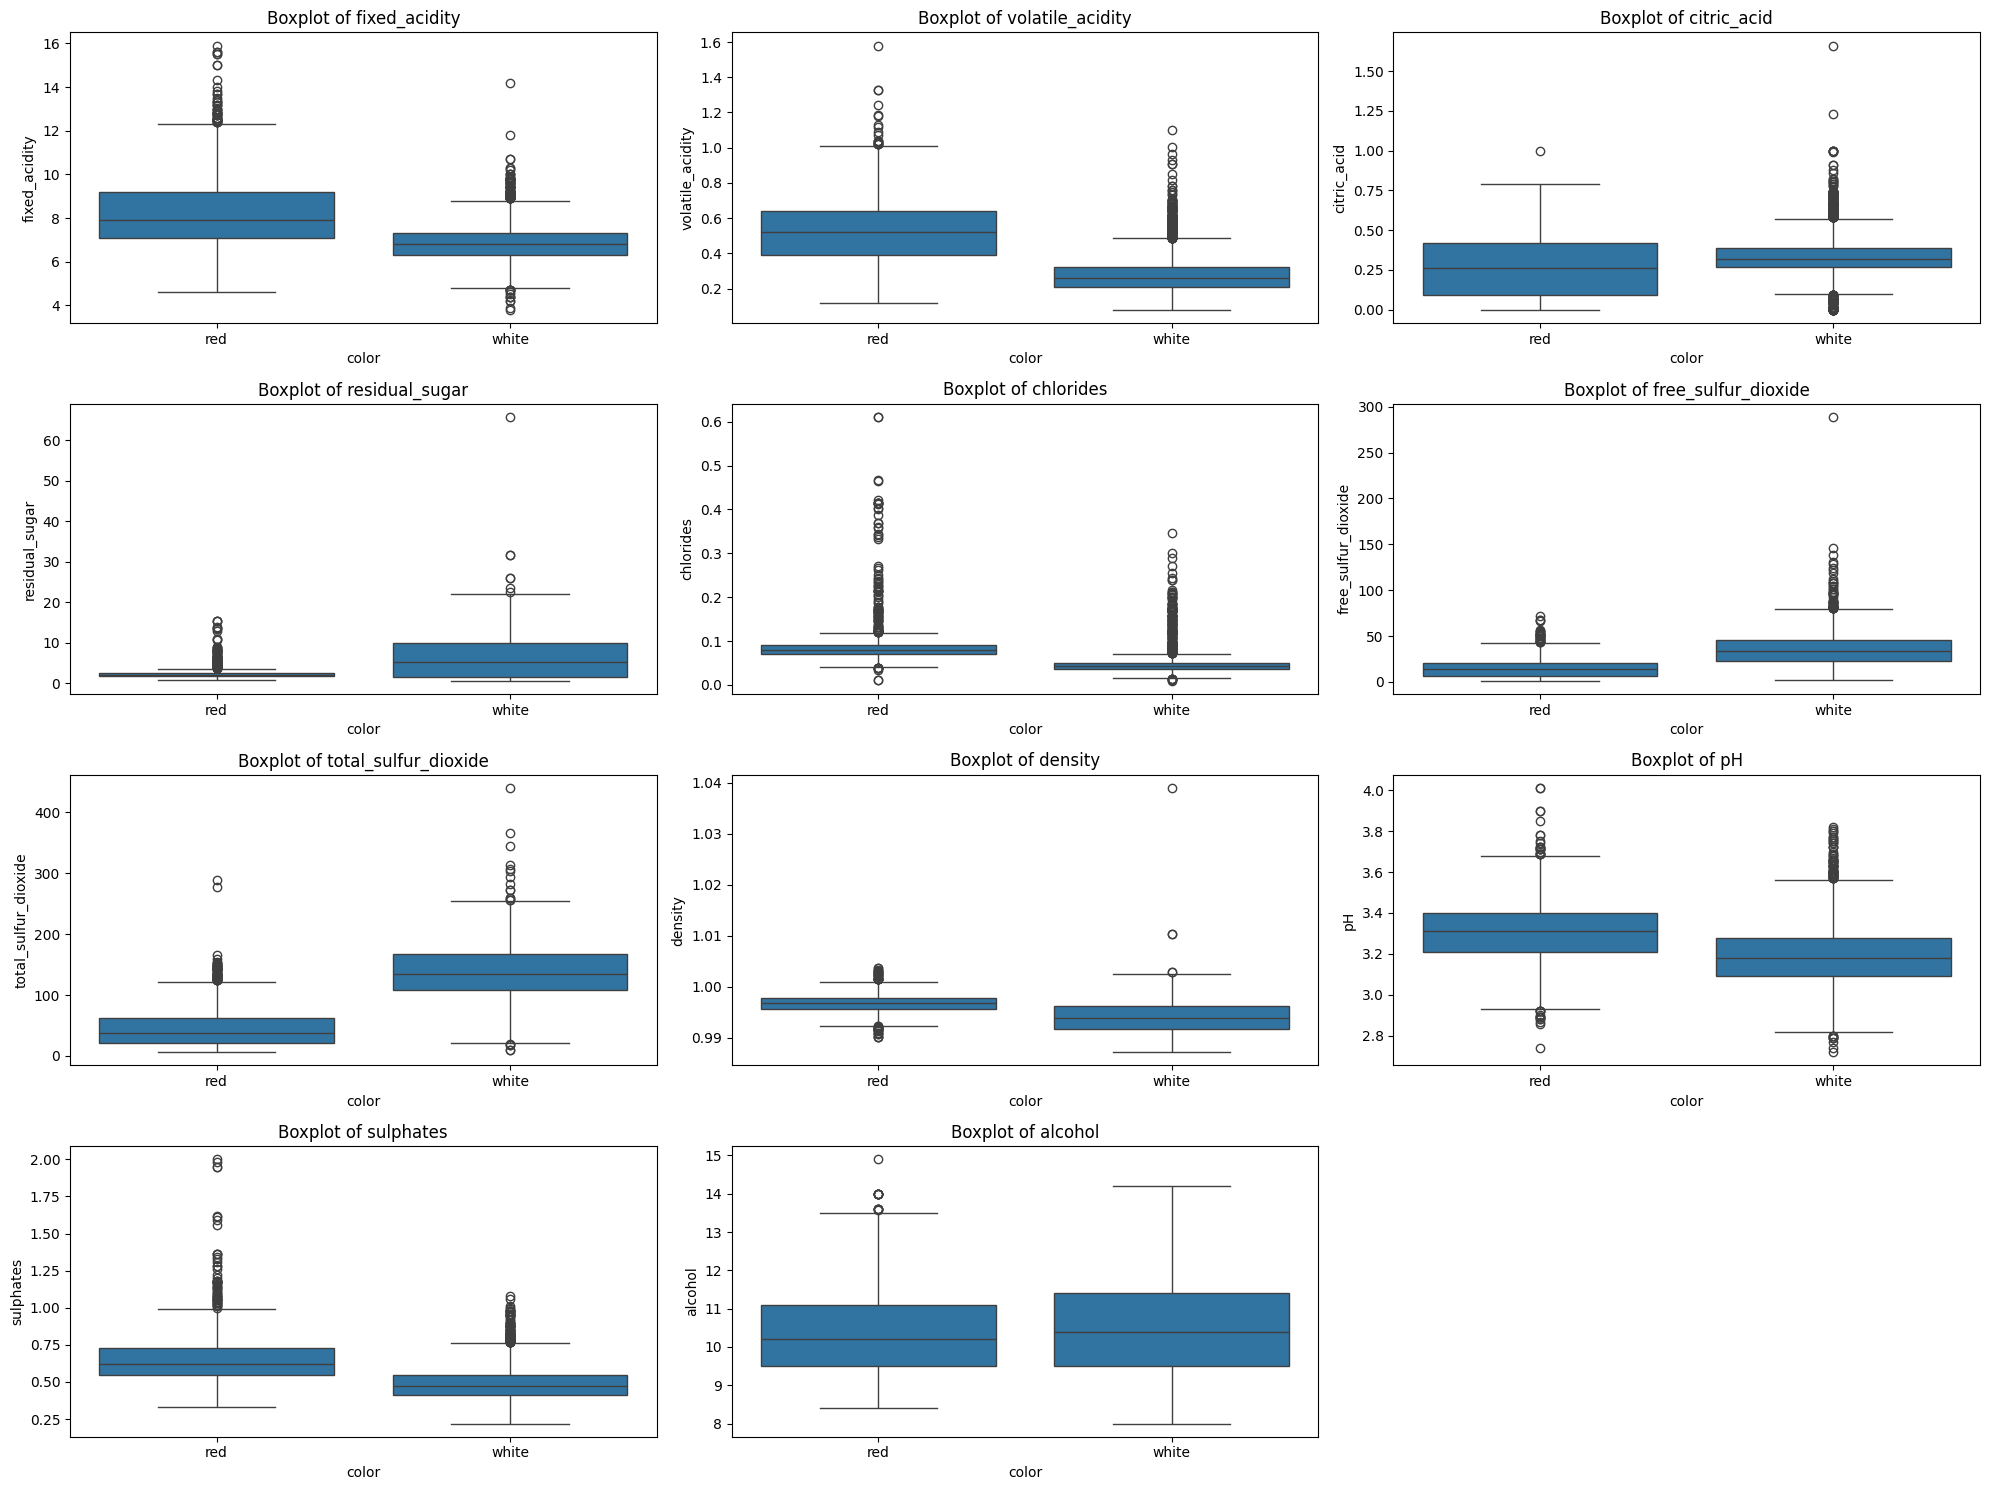

In [9]:
# Complete this cell with your code
# Plotting Boxplots
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x="color", y=feature, data=wine_data)
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

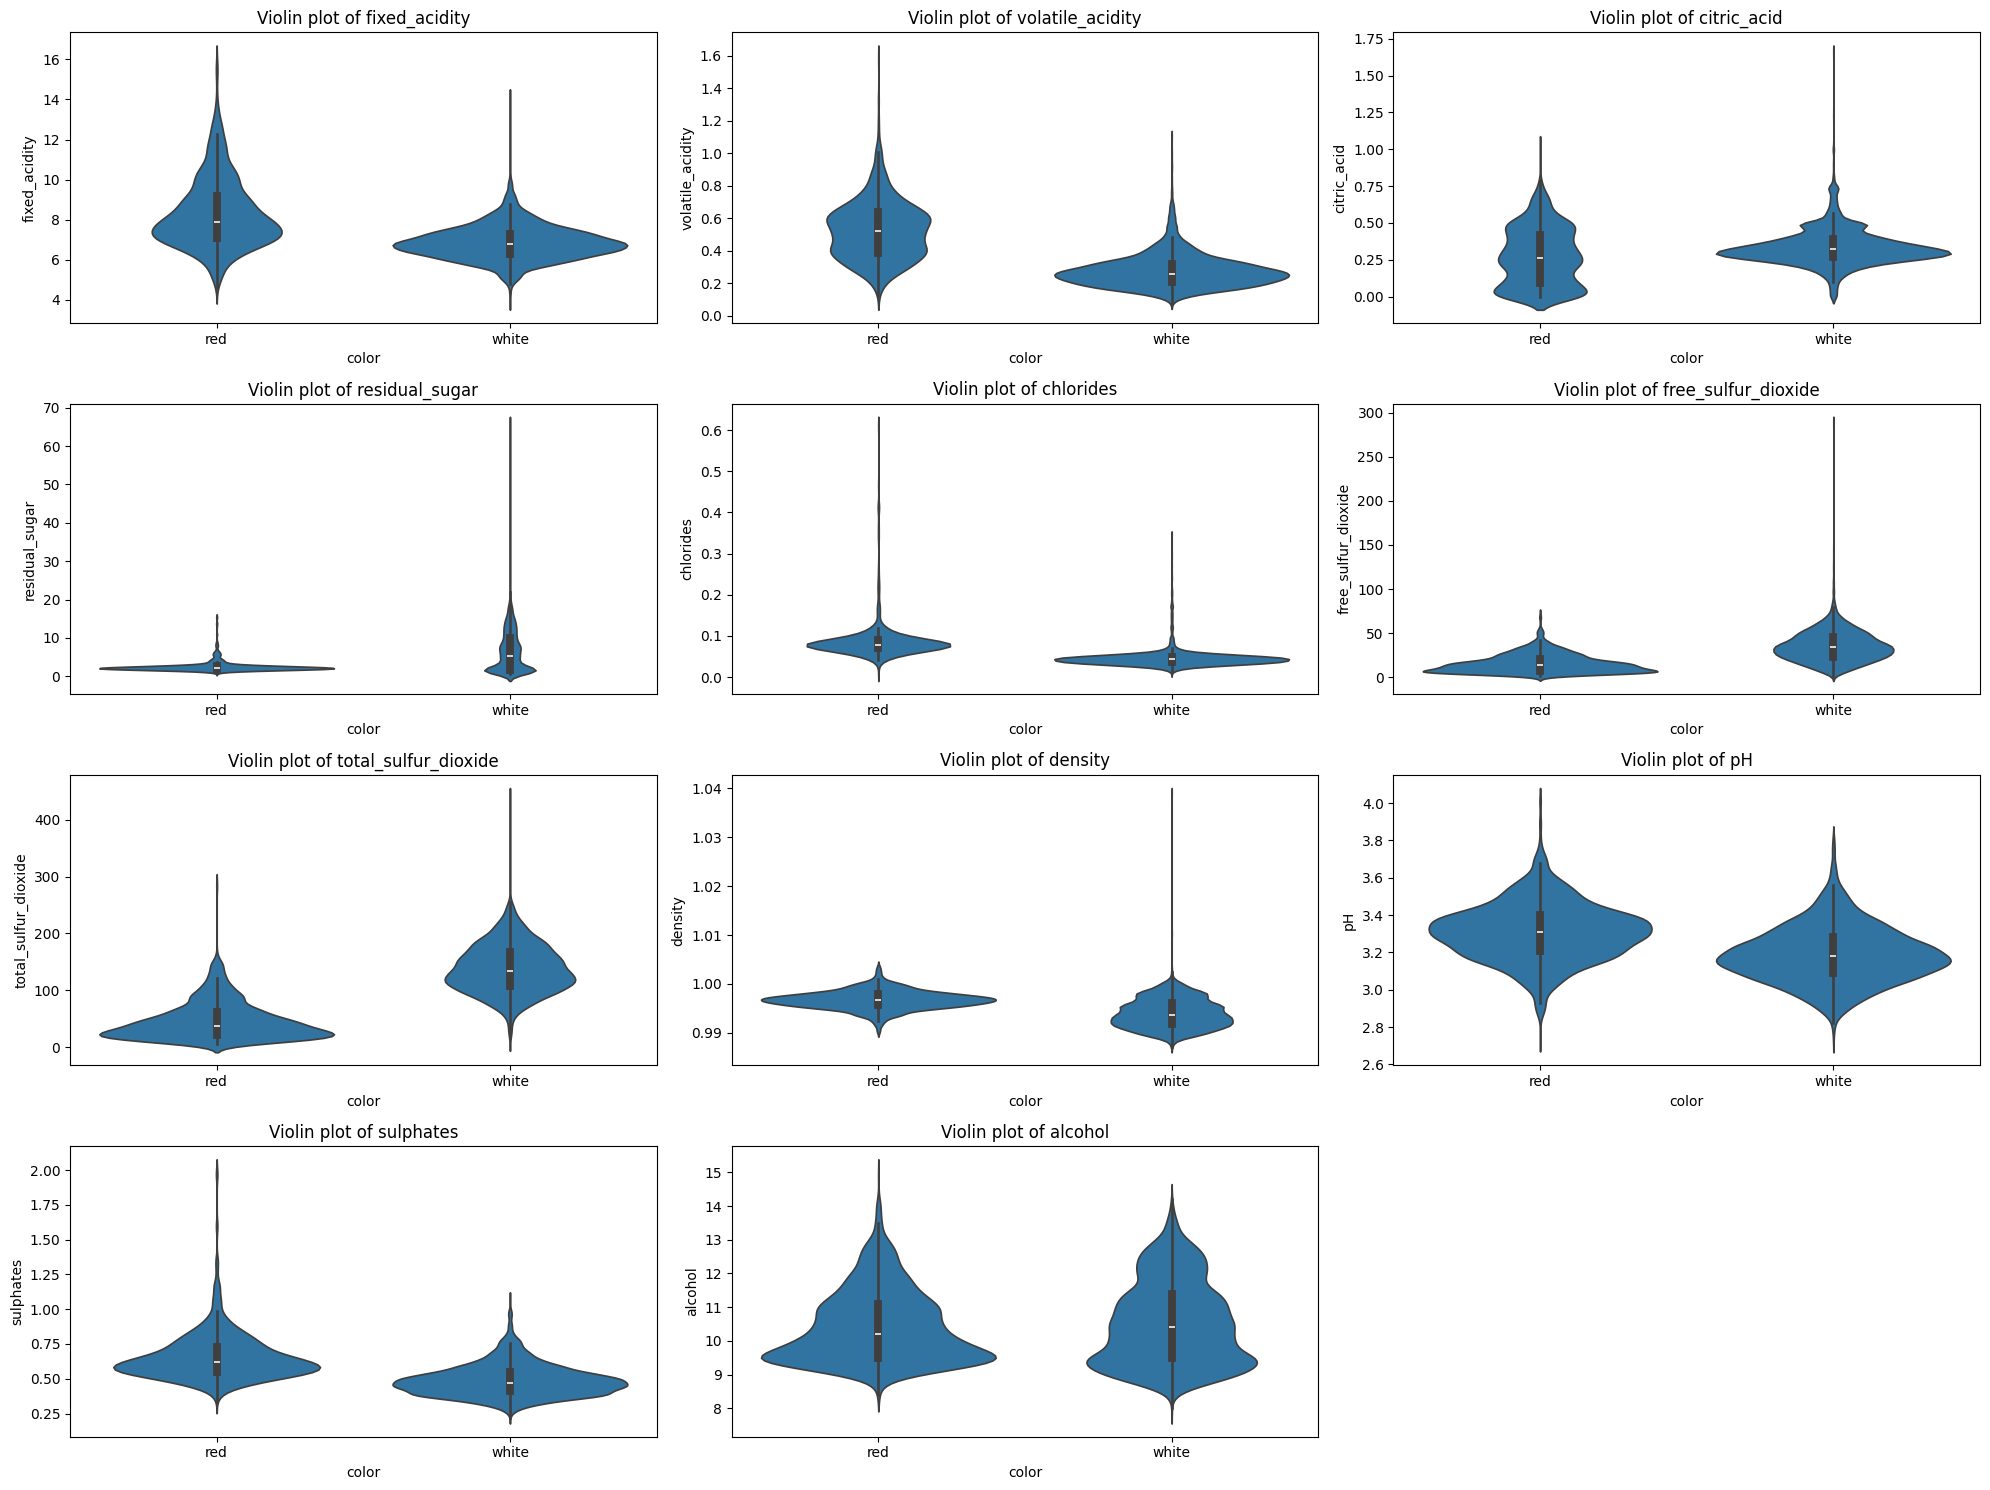

In [10]:
# Plotting Violin plots

plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i + 1)
    sns.violinplot(x="color", y=feature, data=wine_data)
    plt.title(f"Violin plot of {feature}")
plt.tight_layout()
plt.show()

KL Divergence for fixed_acidity: 1.0890365921667329
KL Divergence for volatile_acidity: 1.5342423638430291
KL Divergence for citric_acid: 0.42803674453714297
KL Divergence for residual_sugar: 0.9682514652494512
KL Divergence for chlorides: 2.258266792272121
KL Divergence for free_sulfur_dioxide: 0.7866556160055052
KL Divergence for total_sulfur_dioxide: 2.44272211257932
KL Divergence for density: 0.549970664941112
KL Divergence for pH: 0.284371135925997
KL Divergence for sulphates: 1.262198640698097
KL Divergence for alcohol: 0.038892115178398697


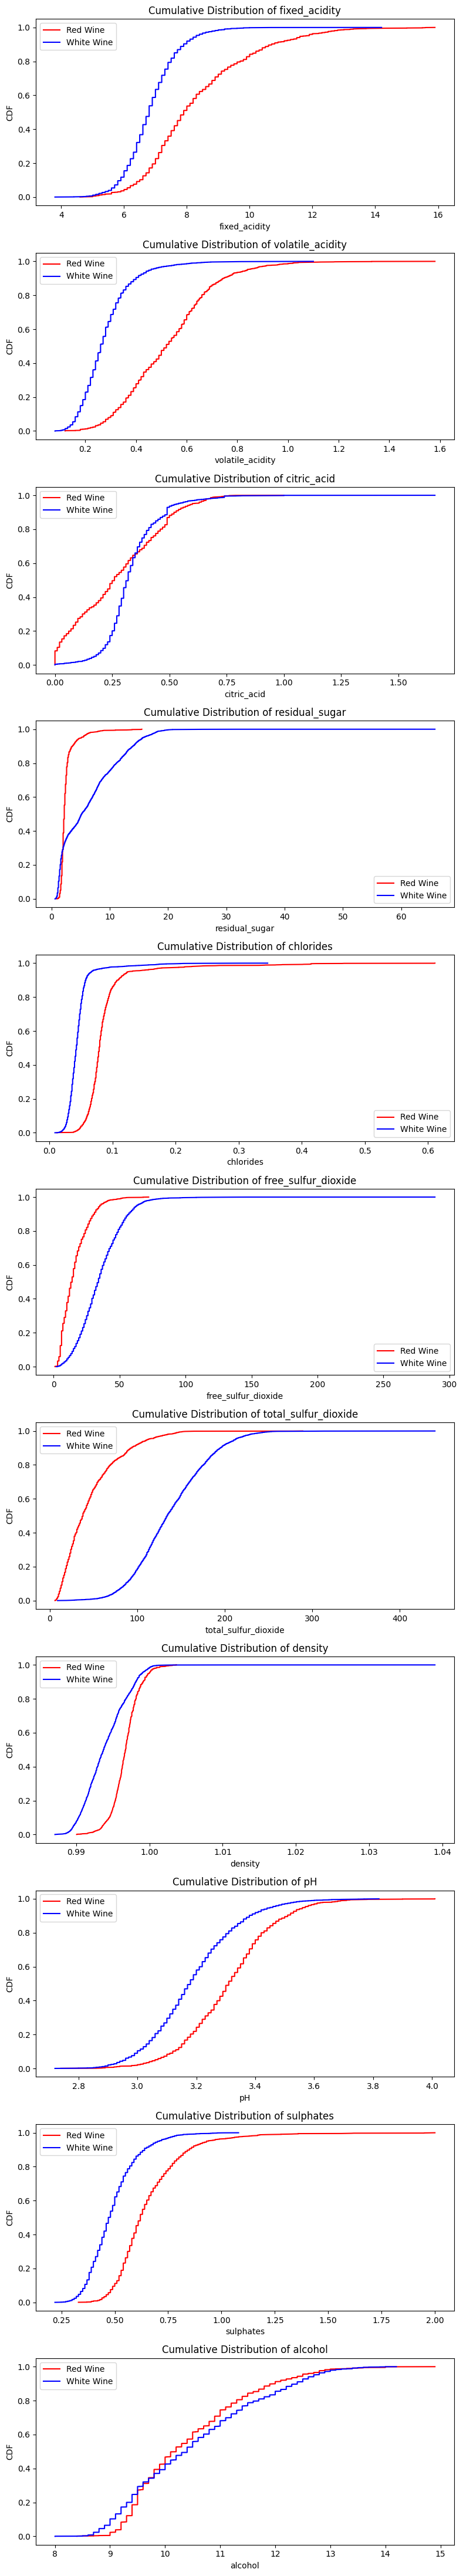

In [63]:
# Function to plot CDFs and calculate KL divergence
def plot_cdf_and_kl(feature, red_data, white_data, ax):
    # Sort the data and compute CDFs
    red_sorted = np.sort(red_data)
    white_sorted = np.sort(white_data)

    red_cdf = np.arange(1, len(red_sorted) + 1) / len(
        red_sorted
    )  # distribute the data points uniformly and then divide by the total number of data points to get the CDF
    white_cdf = np.arange(1, len(white_sorted) + 1) / len(white_sorted)

    # Plot CDFs in the given axis
    ax.plot(red_sorted, red_cdf, label="Red Wine", color="red")
    ax.plot(white_sorted, white_cdf, label="White Wine", color="blue")
    ax.set_title(f"Cumulative Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("CDF")
    ax.legend()

    # Calculate the KL divergence
    # Gaussian KDE help to distribute the data points uniformly and then calculate the entropy, so no point has a 0 value (with correct bandwidth)
    kde_red = gaussian_kde(
        red_data, bw_method=0.4
    )  # bandwidth method is to allow the KDE to be more flexible and don't get 0 values, so we can calculate the entropy without having inf
    kde_white = gaussian_kde(white_data, bw_method=0.4)

    # Compute KL divergence over a common support range
    support = np.linspace(
        min(red_data.min(), white_data.min()),
        max(red_data.max(), white_data.max()),
        100,
    )
    kl_divergence = entropy(kde_red(support), kde_white(support))

    return kl_divergence


# Set up subplots based on the number of features
n_features = len(features)
fig, axes = plt.subplots(n_features, 1, figsize=(8, 4 * n_features))

# Ensure axes are iterable, even if there's only one feature
if n_features == 1:
    axes = [axes]

# Dictionary to store KL divergences
kl_divergences = {}

# Loop through each feature, plotting CDFs and calculating KL divergence
for i, feature in enumerate(features):
    kl_div = plot_cdf_and_kl(feature, red_wine[feature], white_wine[feature], axes[i])
    kl_divergences[feature] = kl_div
    print(f"KL Divergence for {feature}: {kl_div}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

- Volatile acidity, total sulfur dioxid, sulphite, chlorides and fixed acidity have a big KL divergence, meaning that they distinguish a lot between the red and white wines
- Residual Sugar, Free Sulfur Dioxide, Density, Citric Acid, and pH differ less, but should still impact the distinction

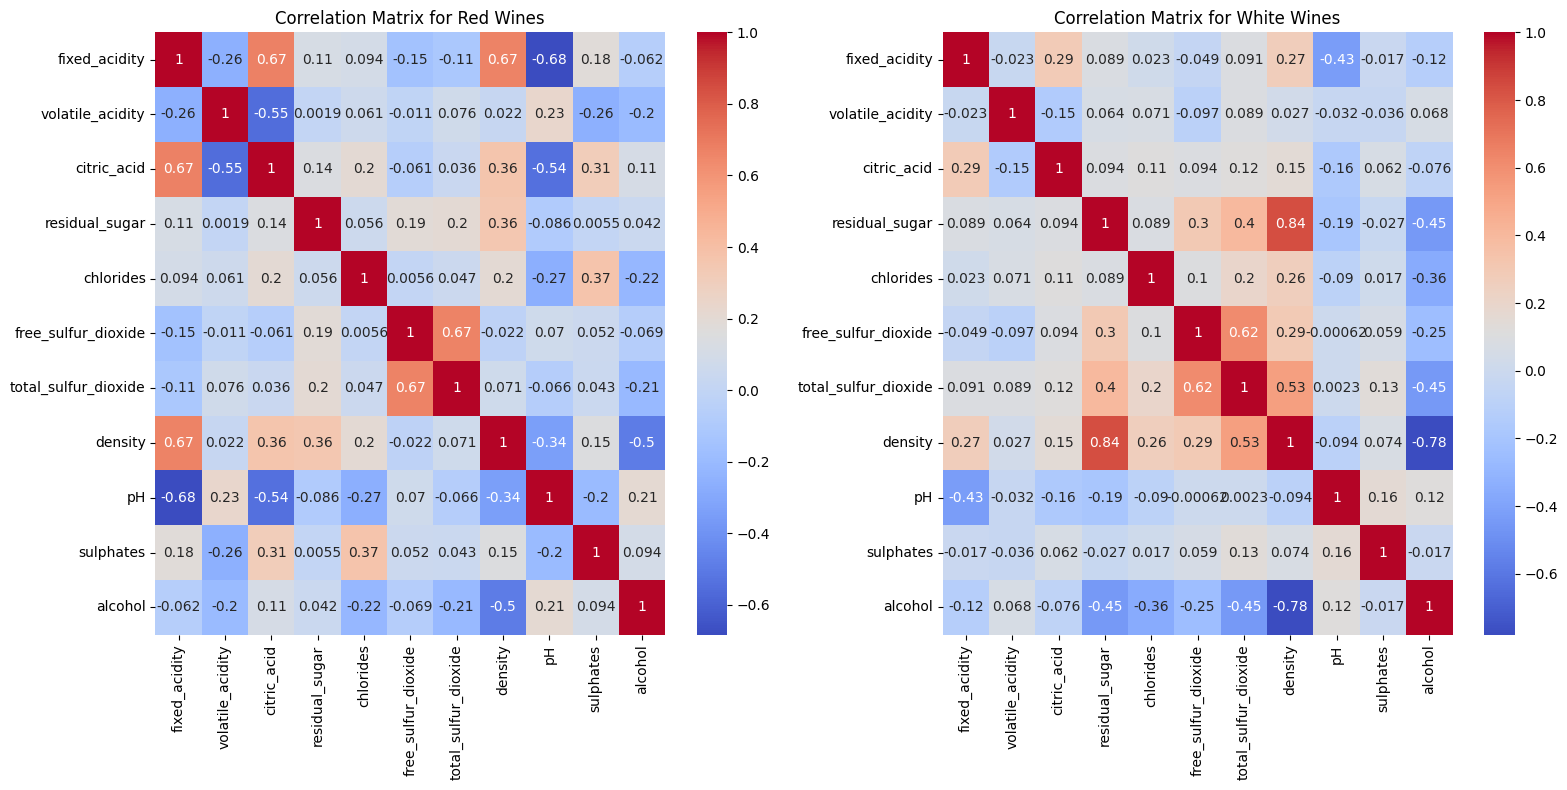

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Correlation heatmap for red wine
sns.heatmap(red_wine[features].corr(), annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Correlation Matrix for Red Wines")

# Correlation heatmap for white wine
sns.heatmap(white_wine[features].corr(), annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Correlation Matrix for White Wines")

plt.tight_layout()

plt.show()

### red wines
- fixed acidity is well correlated with citric acifity, density and pH
- volatile acitidity is a little correlated with citric acidity
- citric acidity is corrlated with pH and little less with density
- residual sugar and density
- chlorides and sulphates
- free sulfur dioxide strongly with total sulfur dioxid
- density with alcool

### white wines
- fixed acidity with pH
- residual sugar strongly with density, and less with free and total sulfur dioxid
- chlorides and alcohol
- free sulfure with total sulfure dioxid
- total sulfur dioxid with density

    - i don't repeat already correlated in upper text


## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

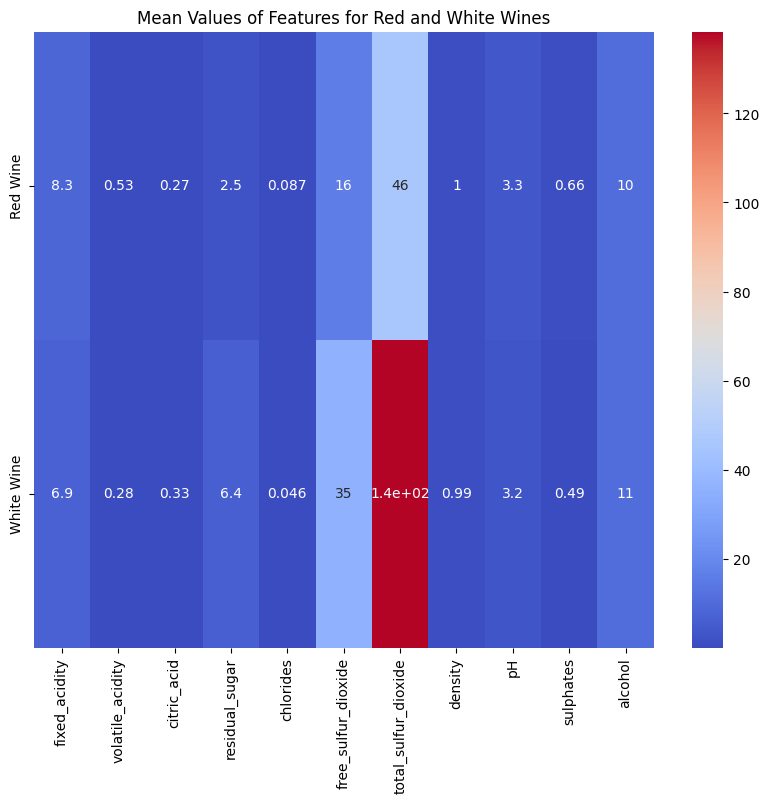

In [13]:
# Complete this cell with your code
red_wine = wine_data[wine_data["color"] == "red"]
white_wine = wine_data[wine_data["color"] == "white"]

red_means = red_wine[features].mean()
white_means = white_wine[features].mean()

# create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.DataFrame([red_means, white_means], index=["Red Wine", "White Wine"]),
    annot=True,
    cmap="coolwarm",
)
plt.title("Mean Values of Features for Red and White Wines")
plt.show()

### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

NameError: name 'pca_2' is not defined

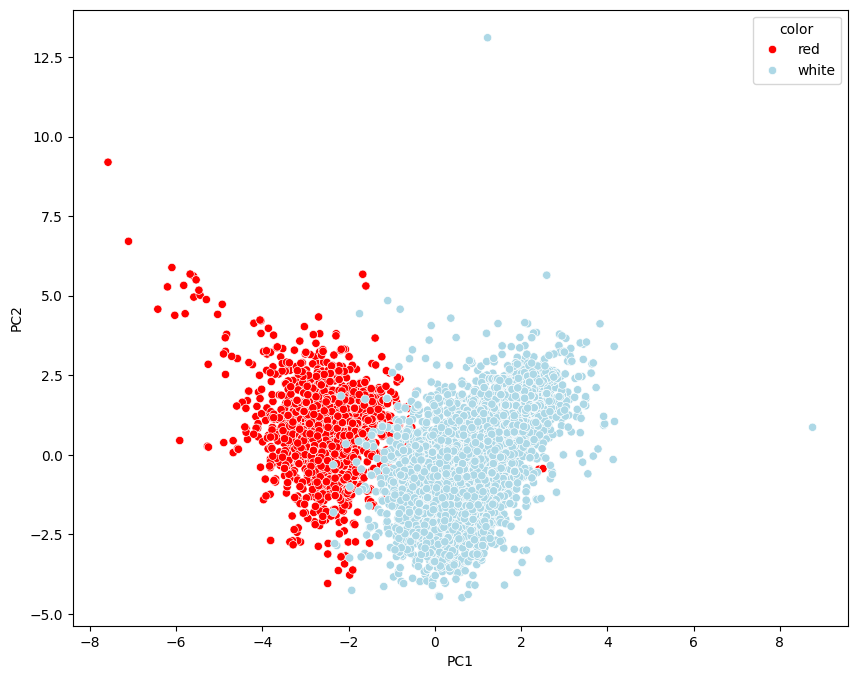

In [65]:
# Complete this cell with your code
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X = wine_data.drop(columns=["quality", "color"])
y = wine_data["quality"]

X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["color"] = wine_data["color"]
pca_df["quality"] = wine_data["quality"]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", y="PC2", hue="color", data=pca_df, palette=["red", "lightblue"]
)

plt.title("PCA of Wine Dataset")
plt.ylabel("Principal Component 2")
plt.legend(title="Color", loc="upper right")

plt.show()

### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

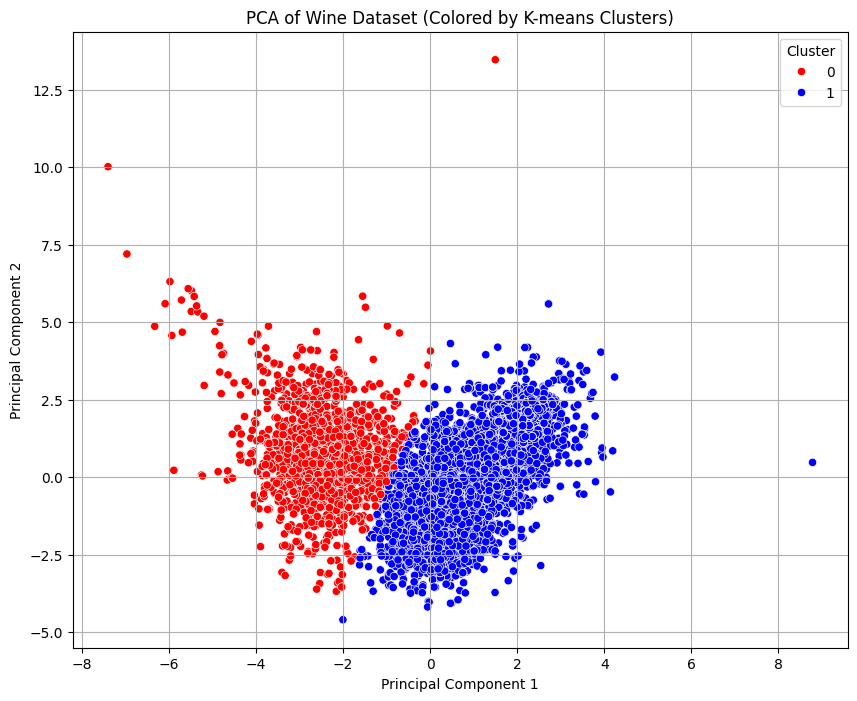

Mutual Information Score: 0.4807
Accuracy: 0.9828
F1 Score: 0.9885


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, mutual_info_score
from sklearn.preprocessing import LabelEncoder

kmeans = KMeans(n_clusters=2, random_state=42)
y_clusters = kmeans.fit_predict(X_pca)

# Add the cluster assignments to the PCA DataFrame
pca_df["Cluster"] = y_clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette=["red", "blue"])
plt.title("PCA of Wine Dataset (Colored by K-means Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.grid(True)
plt.show()

label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(pca_df["color"])

# Adjust cluster labels for accuracy/f1 score comparison
# KMeans cluster labels may not align with the true labels, so we need to map them
if accuracy_score(true_labels, y_clusters) < 0.5:
    # If accuracy is less than 0.5, invert the cluster labels
    y_clusters = 1 - y_clusters

mi_score = mutual_info_score(true_labels, y_clusters)
accuracy = accuracy_score(true_labels, y_clusters)
f1 = f1_score(true_labels, y_clusters)

print(f"Mutual Information Score: {mi_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

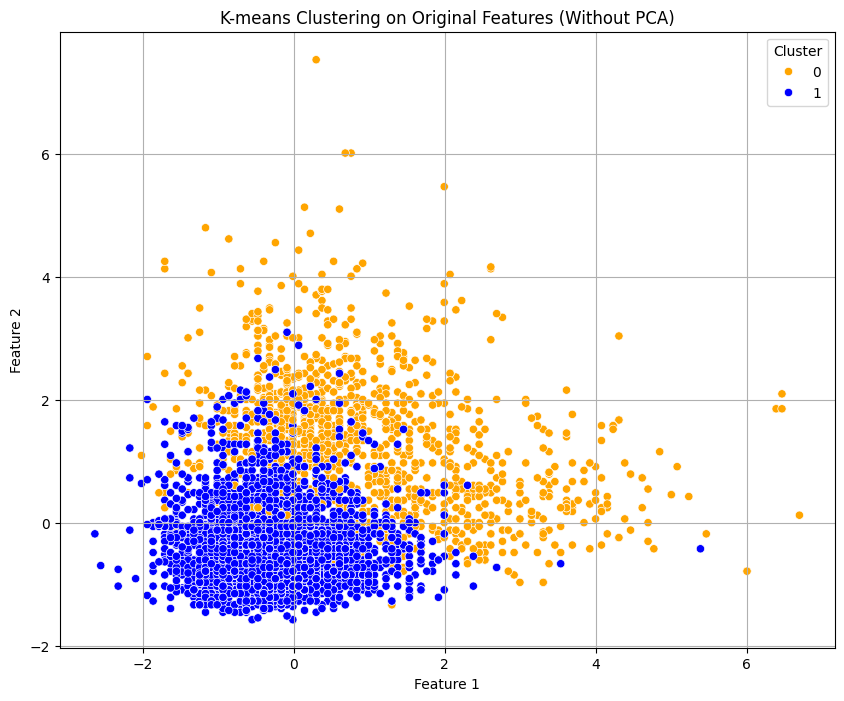

Mutual Information Score: 0.4911
Accuracy: 0.9858
F1 Score: 0.9906


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, mutual_info_score
from sklearn.preprocessing import LabelEncoder

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=clusters,
    palette=["red", "blue"],
)
plt.title("K-means Clustering on Original Features (Without PCA)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster", loc="upper right")
plt.grid(True)
plt.show()

label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(wine_data["color"])

# Adjust cluster labels for accuracy/f1 score comparison
# KMeans cluster labels may not align with the true labels, so we need to map them
if accuracy_score(true_labels, clusters) < 0.5:
    # If accuracy is less than 0.5, invert the cluster labels
    clusters = 1 - clusters

mi_score = mutual_info_score(true_labels, clusters)
accuracy = accuracy_score(true_labels, clusters)
f1 = f1_score(true_labels, clusters)

print(f"Mutual Information Score: {mi_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

Best C: 7.373469387755102
Best Score: 0.9890323535944325
Accuracy Score: 0.9830769230769231
F1 Score: 0.9829948949736295


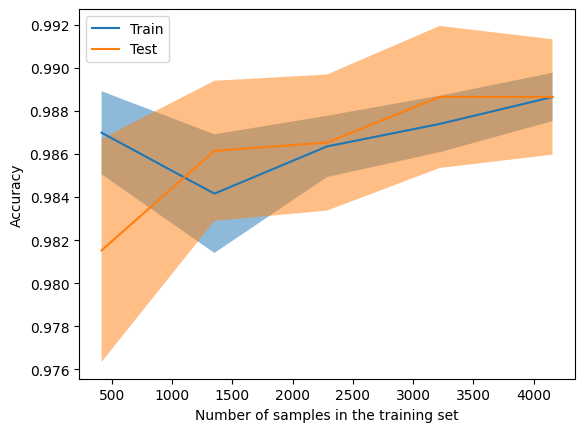

In [18]:
# Complete this cell with your code
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LearningCurveDisplay

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(wine_data["color"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

param_grid = {
    "C": np.linspace(0.1, 10),
}

log_reg = LogisticRegression(max_iter=2000, random_state=42)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_["C"]
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best Score: {best_score}")

grid_search.best_estimator_.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average="weighted")
print(f"Test Accuracy Score: {accuracy}")
print(f"Test F1 Score: {f1}")

LearningCurveDisplay.from_estimator(
    grid_search.best_estimator_, X_train, y_train, cv=5, scoring="accuracy"
)

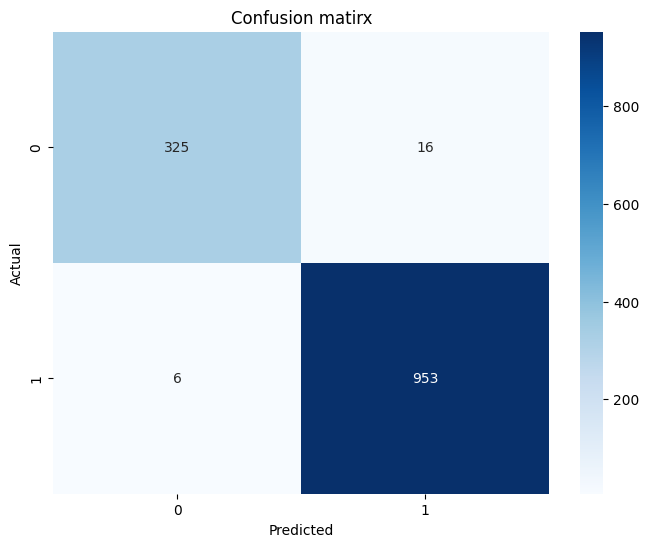

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matirx")
plt.show()

- We can see that the model is more subject to false positive compared to false negative, it's probably due to the imbalance of the data

In [20]:
""" # use a polynomial kernel
from sklearn.svm import SVC

param_grid = {
    "C": np.linspace(1e-4, 10),
    "degree": [2, 3, 4],
}

svc = SVC(kernel="poly", random_state=42)

grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_["C"]
best_degree = grid_search.best_params_["degree"]
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best Degree: {best_degree}")
print(f"Best Score: {best_score}")

grid_search.best_estimator_.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1}") """

' # use a polynomial kernel\nfrom sklearn.svm import SVC\n\nparam_grid = {\n    "C": np.linspace(1e-4, 10),\n    "degree": [2, 3, 4],\n}\n\nsvc = SVC(kernel="poly", random_state=42)\n\ngrid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\nbest_C = grid_search.best_params_["C"]\nbest_degree = grid_search.best_params_["degree"]\nbest_score = grid_search.best_score_\n\nprint(f"Best C: {best_C}")\nprint(f"Best Degree: {best_degree}")\nprint(f"Best Score: {best_score}")\n\ngrid_search.best_estimator_.fit(X_train, y_train)\n\ny_pred = grid_search.best_estimator_.predict(X_test)\n\naccuracy = accuracy_score(y_test, y_pred)\nf1 = f1_score(y_test, y_pred, average="weighted")\n\nprint(f"Accuracy Score: {accuracy}")\nprint(f"F1 Score: {f1}") '

### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

                      Coefficient
alcohol                  0.565932
citric_acid              0.278890
residual_sugar           0.120941
total_sulfur_dioxide     0.067406
free_sulfur_dioxide     -0.058213
density                 -1.196906
fixed_acidity           -1.366515
pH                      -7.829302
sulphates               -8.641449
chlorides              -11.148580
volatile_acidity       -12.033861


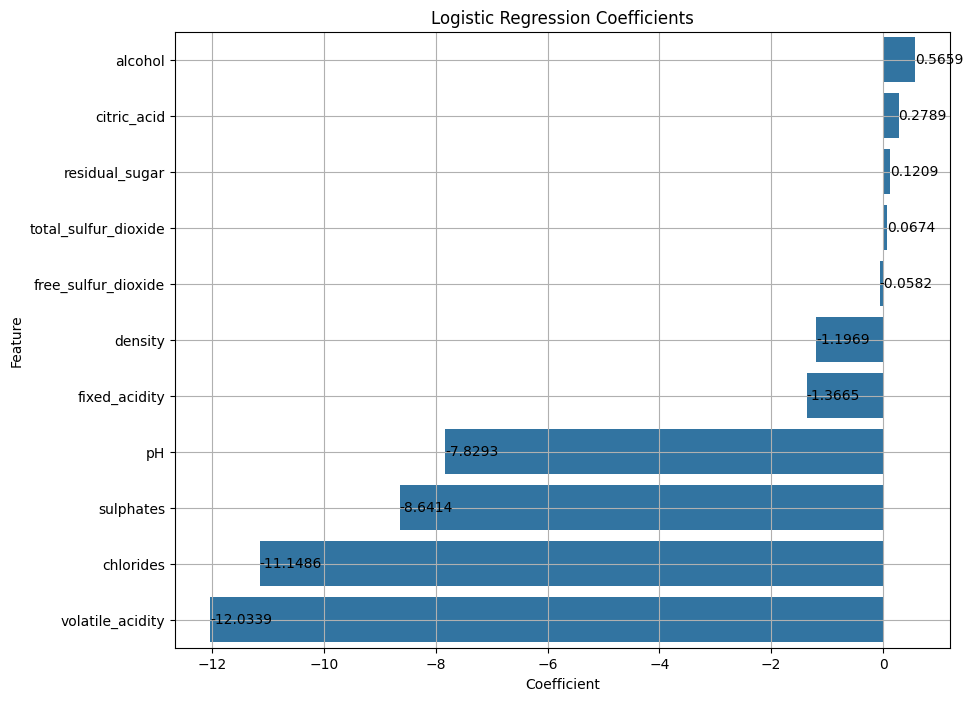

In [21]:
# Complete this cell with your code

# After training the logistic regression model (best_log_reg)
coefficients = pd.DataFrame(
    grid_search.best_estimator_.coef_[0], index=X.columns, columns=["Coefficient"]
)

# Display the coefficients
coefficients_sorted = coefficients.sort_values(by="Coefficient", ascending=False)

print(coefficients_sorted)

plt.figure(figsize=(10, 8))
sns.barplot(x="Coefficient", y=coefficients_sorted.index, data=coefficients_sorted)
for index, value in enumerate(coefficients_sorted["Coefficient"]):
    plt.text(value, index, f"{value:.4f}", va="center", color="black")
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [22]:
# Complete this cell with your code
# remove volatile acidity and chlorides
# X_rem = X.drop(columns=["total_sulfur_dioxide"])
# X_rem = X.drop(columns=["citric_acid", "alcohol", "residual_sugar", "total_sulfur_dioxide"])

X_rem = X.drop(
    columns=["volatile_acidity", "chlorides", "sulphates", "pH"]
    # columns=["volatile_acidity", "chlorides", "sulphates", "pH", "total_sulfur_dioxide"]
)

X_train_rem, X_test_rem, y_train_rem, y_test_rem = train_test_split(
    X_rem, y_encoded, test_size=0.2, random_state=42
)

param_grid = {
    "C": np.linspace(0.1, 10),
}

log_reg_rem = LogisticRegression(
    max_iter=2000, random_state=42, penalty="l1", solver="liblinear"
)

grid_search_rem = GridSearchCV(log_reg_rem, param_grid, cv=5, n_jobs=-1)

grid_search_rem.fit(X_train_rem, y_train_rem)

best_C_rem = grid_search_rem.best_params_["C"]

print(f"Best C: {best_C_rem}")

grid_search_rem.best_estimator_.fit(X_train_rem, y_train_rem)

y_pred_rem = grid_search_rem.best_estimator_.predict(X_test_rem)

accuracy_rem = accuracy_score(y_test_rem, y_pred_rem)
f1_rem = f1_score(y_test_rem, y_pred_rem, average="weighted")

print(f"Accuracy Score: {accuracy_rem}")
print(f"F1 Score: {f1_rem}")

Best C: 0.5040816326530613
Accuracy Score: 0.9407692307692308
F1 Score: 0.9400233658446139


- Even removing some important features, we lost "only" few percents
- Same for L1 regul
- We can be pretty confident we choose the correct type of wines, however the data is imbalanced

### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

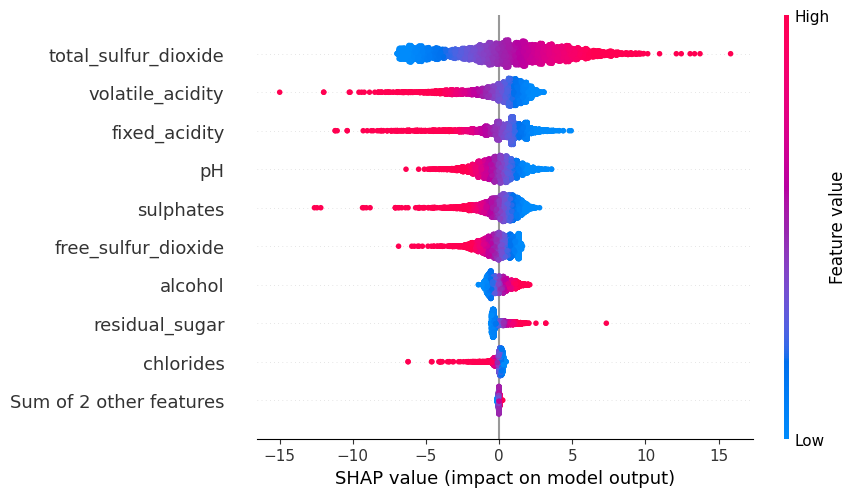

In [23]:
# Complete this cell with your code
import shap

# Create a SHAP explainer
explainer = shap.Explainer(grid_search.best_estimator_, X_train)
shap_values = explainer(X_train)

# Plot the SHAP summary plot
shap.plots.beeswarm(shap_values)

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

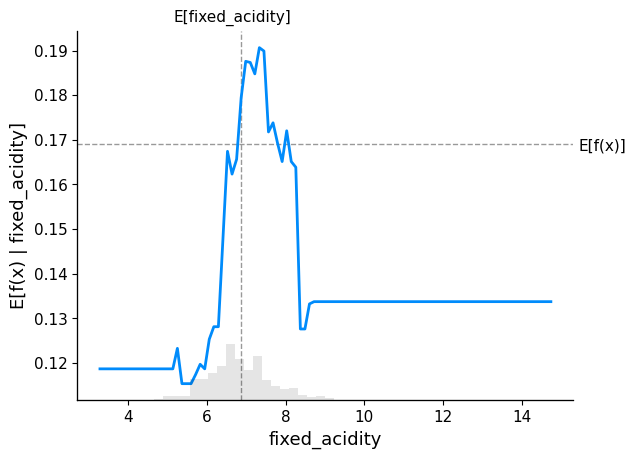

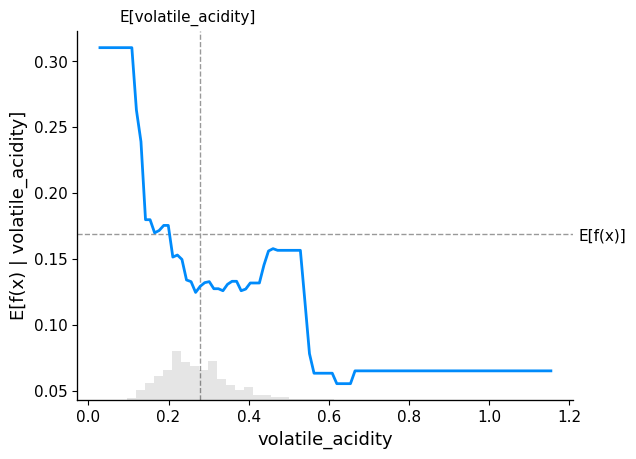

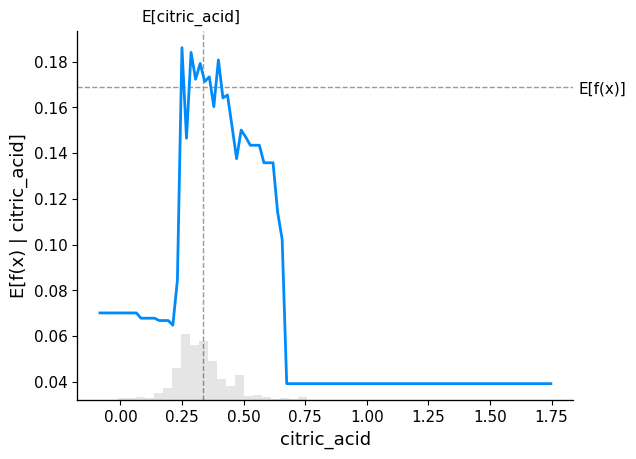

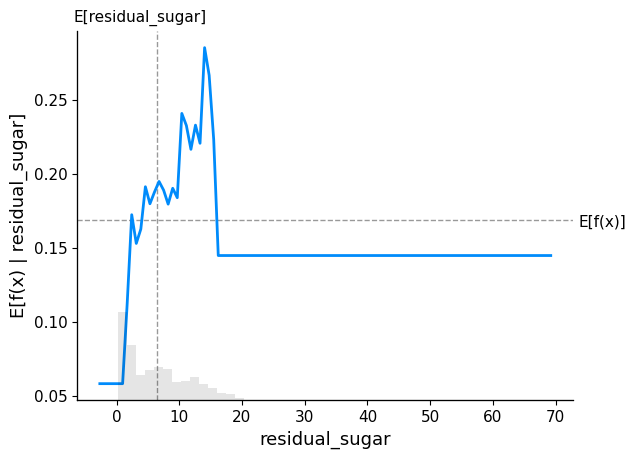

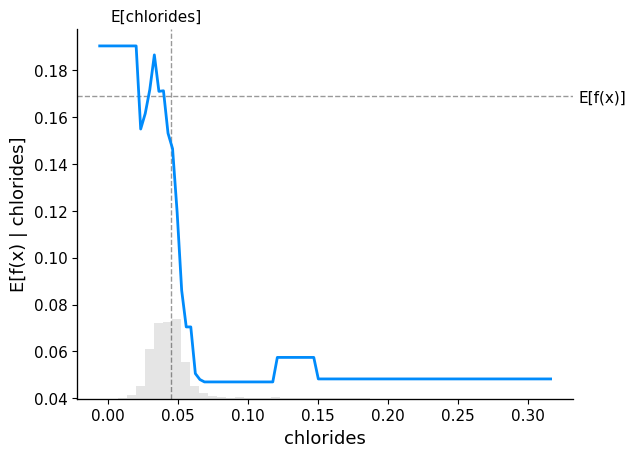

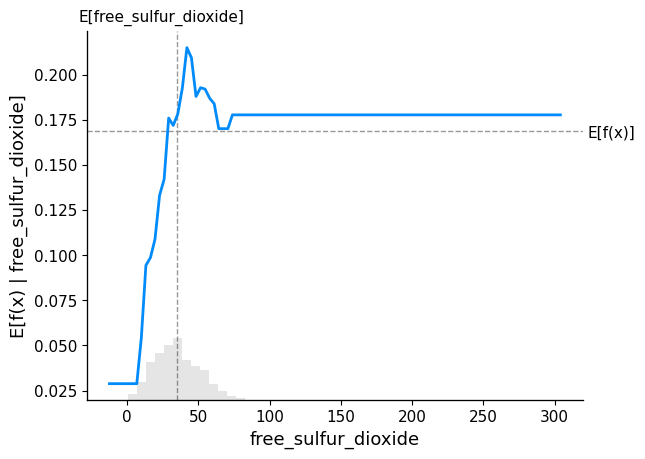

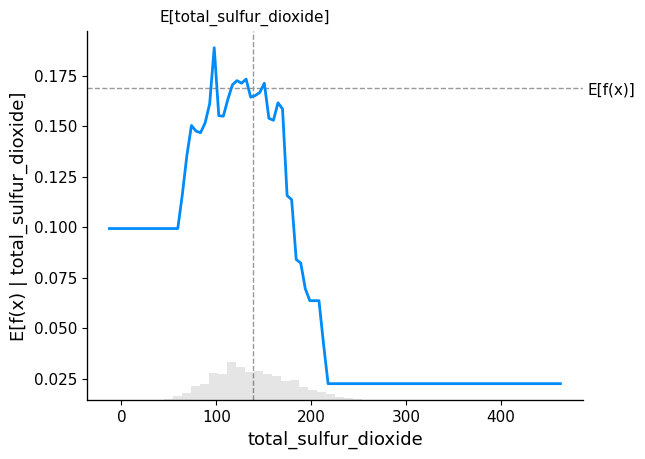

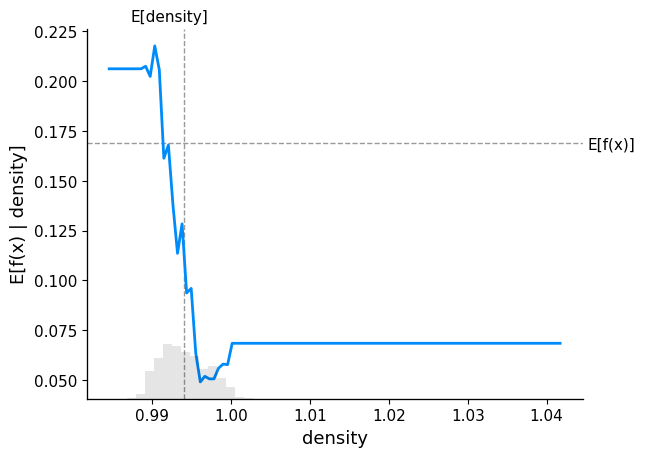

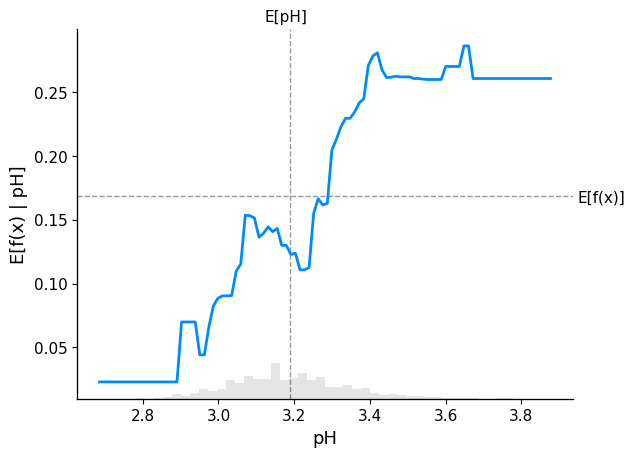

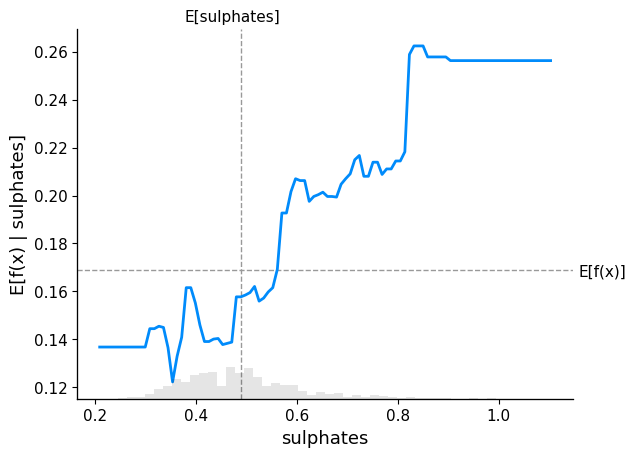

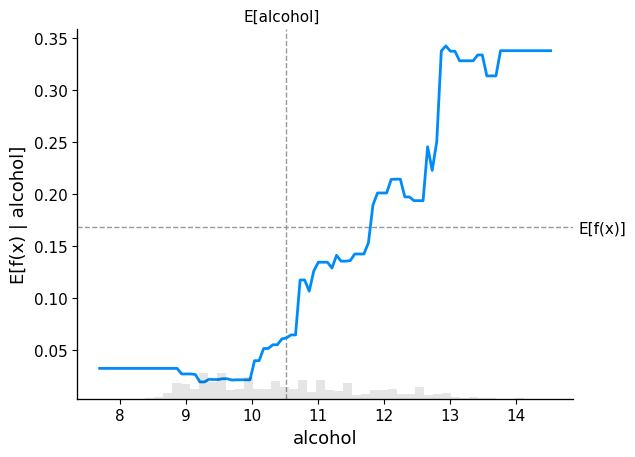

In [83]:
for column in X_train.columns:
    shap.partial_dependence_plot(
        column,
        grid_search.best_estimator_.predict,
        X_train,
        ice=False,  # disable individual conditional expectation plots
        model_expected_value=True,
        feature_expected_value=True,
    )

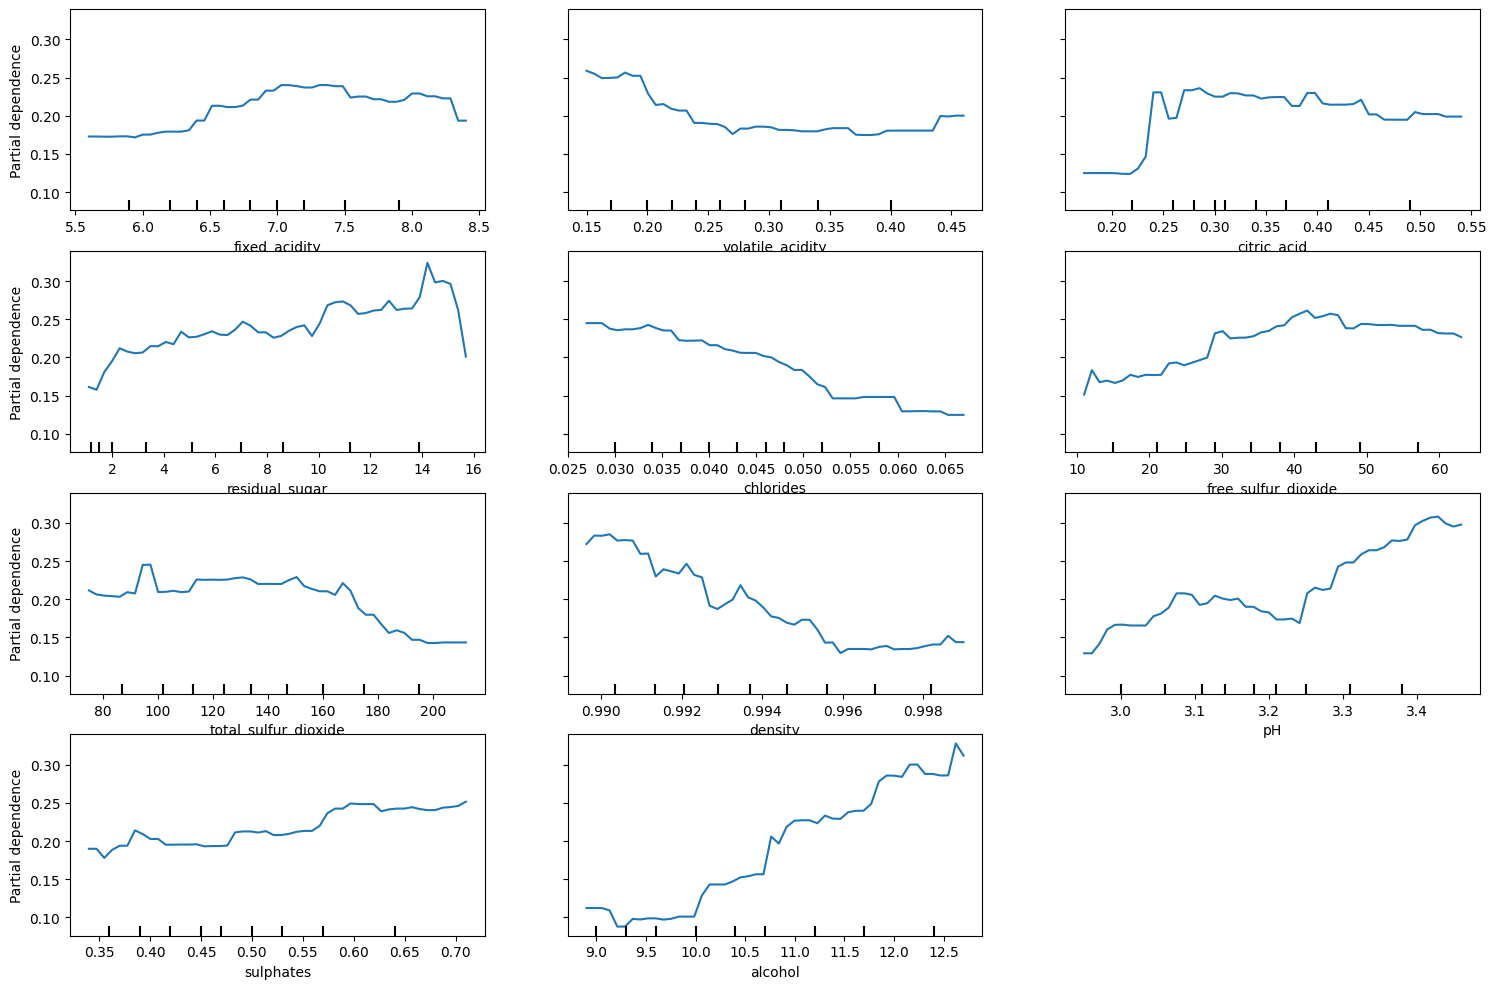

In [68]:
# Complete this cell with your code
from sklearn.inspection import PartialDependenceDisplay

features = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(
    grid_search.best_estimator_,
    X_train,
    features,
    ax=ax,
    grid_resolution=50,
    kind="average",
)
plt.tight_layout()
plt.show()

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

In [81]:
print(label_encoder.inverse_transform(y_test[:3]))

['red' 'red' 'red']
['red' 'red' 'red']


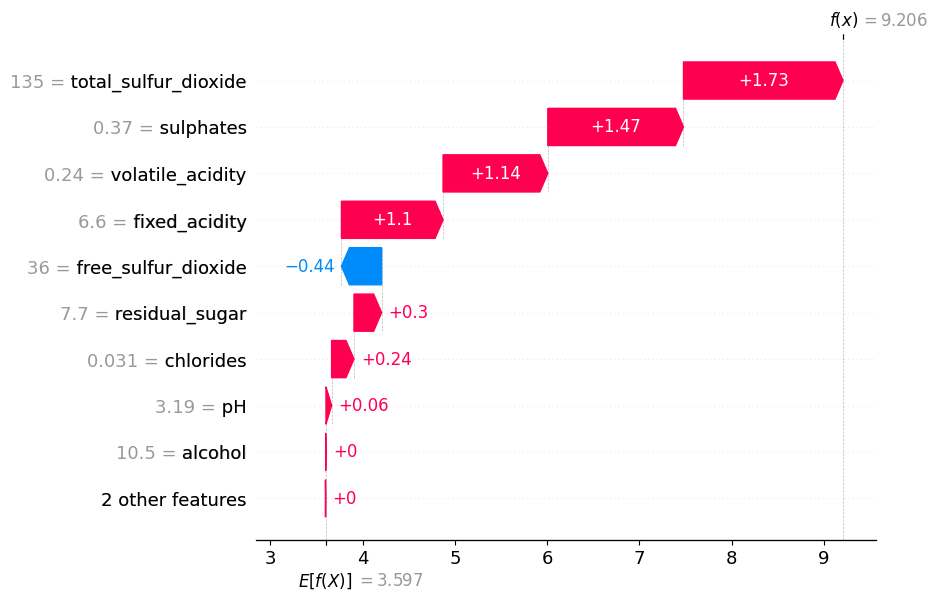

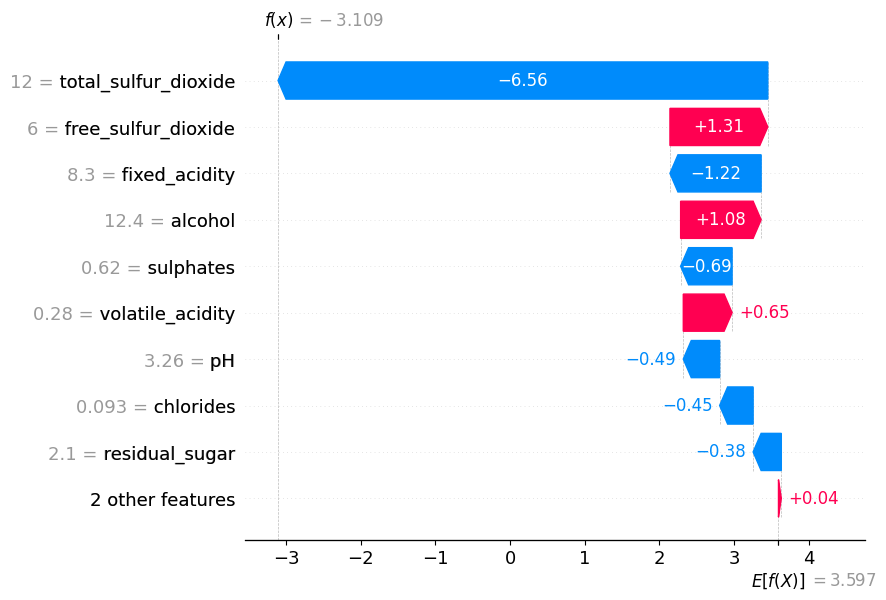

In [25]:
# Complete this cell with your code
explainer = shap.Explainer(grid_search.best_estimator_, X_train)
shap_values = explainer(X_train)

for id in range(2):
    shap.waterfall_plot(shap_values[id])

- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

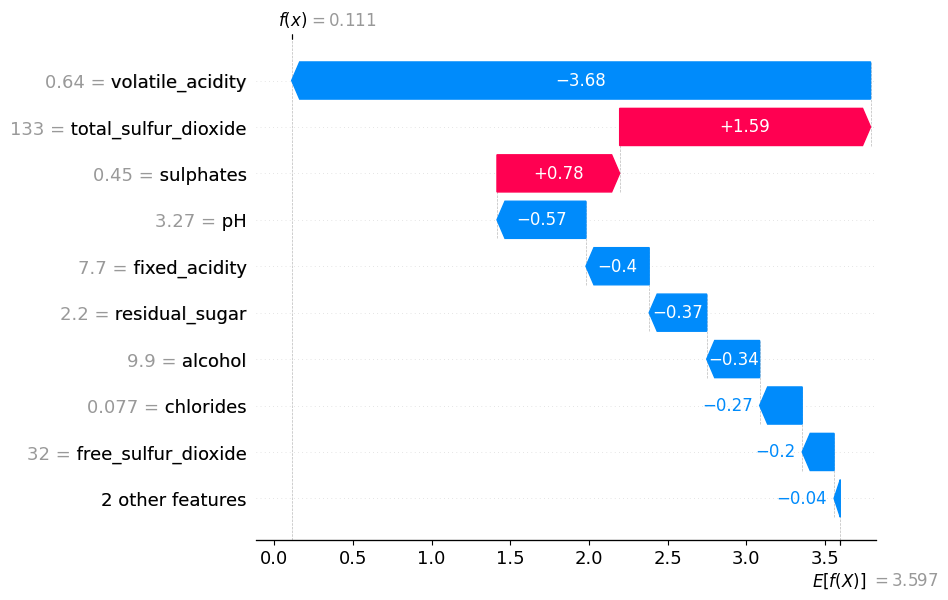

<Figure size 640x480 with 0 Axes>

In [26]:
# Complete this cell with your code
errors = np.abs(y_pred - y_test)  # Calculate absolute errors
incorrect_idx = np.argmax(errors)  # Find the index with the largest error

explainer = shap.Explainer(grid_search.best_estimator_, X_train)
shap_values = explainer(X_test)

fig, ax = plt.subplots(figsize=(10, 8))
shap.waterfall_plot(shap_values[incorrect_idx])
ax.set_title(f"SHAP Waterfall Plot for Incorrect Prediction (Index {incorrect_idx})")

plt.tight_layout()
plt.show()

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [27]:
# Complete this cell with your code
wine_data["binary_quality"] = wine_data["quality"].apply(lambda x: 1 if x > 6 else 0)

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

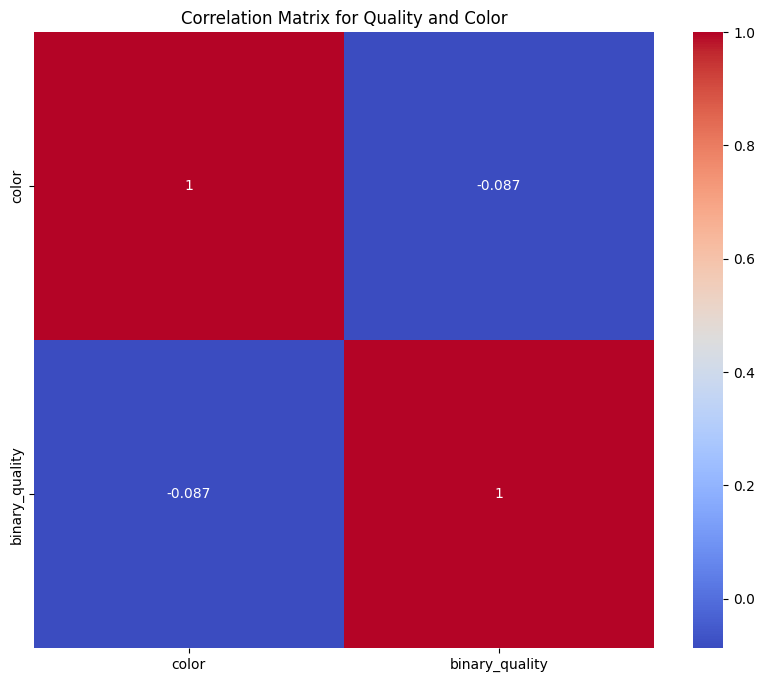

' wine_corr = wine_data.copy()\nwine_corr.drop(\n    columns=[\n        "fixed_acidity",\n        "volatile_acidity",\n        "citric_acid",\n        "residual_sugar",\n        "chlorides",\n        "free_sulfur_dioxide",\n        "total_sulfur_dioxide",\n        "density",\n        "pH",\n        "sulphates",\n        "alcohol",\n        "quality",\n    ],\n    inplace=True,\n)\nwine_corr["color"] = wine_corr["color"].apply(lambda x: 1 if x == "red" else 0)\n\nwine_corr.corr()\n\nplt.figure(figsize=(10, 8))\nsns.heatmap(wine_corr.corr(), annot=True, cmap="coolwarm")\nplt.title("Correlation Matrix for Binary Quality and Color")\nplt.show() '

In [80]:
# Complete this cell with your code

wine_corr = wine_data.copy()

# Convert color to binary (red = 1, white = 0)
wine_corr["color"] = wine_corr["color"].apply(lambda x: 1 if x == "red" else 0)

# Keeping only 'quality' and 'color' to explore their correlation
wine_corr = wine_corr[["color", "binary_quality"]]

corr_matrix = wine_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Quality and Color")
plt.show()

""" wine_corr = wine_data.copy()
wine_corr.drop(
    columns=[
        "fixed_acidity",
        "volatile_acidity",
        "citric_acid",
        "residual_sugar",
        "chlorides",
        "free_sulfur_dioxide",
        "total_sulfur_dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
        "quality",
    ],
    inplace=True,
)
wine_corr["color"] = wine_corr["color"].apply(lambda x: 1 if x == "red" else 0)

wine_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(wine_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Binary Quality and Color")
plt.show() """

In [29]:
# Mean of binary quality for each color
mean_binary_quality = wine_data.groupby("color")["binary_quality"].mean()

print(mean_binary_quality)

color
red      0.135710
white    0.216415
Name: binary_quality, dtype: float64


- only 0.087 of correlation, so no correlation between color and quality
- However only 13% of the red wines are good, against 21% for white ones

If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

- If the dataset is imbalanced, the feature importance could be impacted.
    - We should separate red wine to the white wines   

Text(0.5, 1.0, 'Mean Values of Features for Good and Bad Wines')

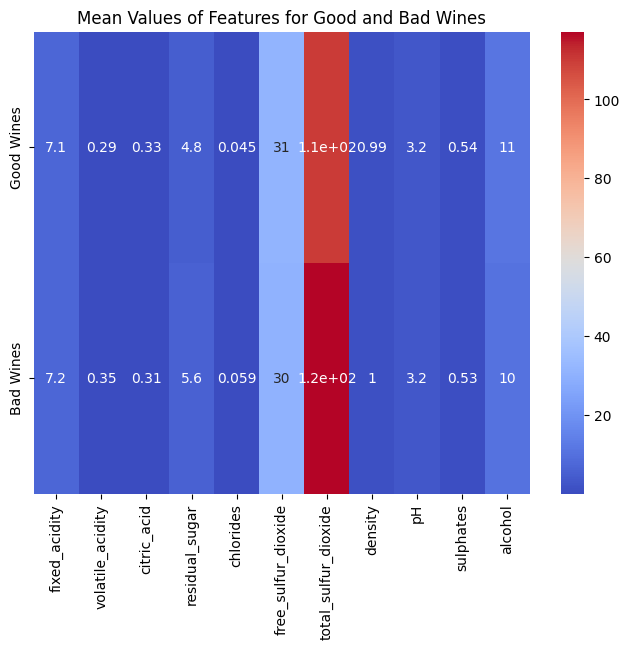

In [49]:
good_wines = wine_data[wine_data["binary_quality"] == 1]
bad_wines = wine_data[wine_data["binary_quality"] == 0]

good_means = good_wines[features].mean()
bad_means = bad_wines[features].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame([good_means, bad_means], index=["Good Wines", "Bad Wines"]),
    annot=True,
    cmap="coolwarm",
)
plt.title("Mean Values of Features for Good and Bad Wines")

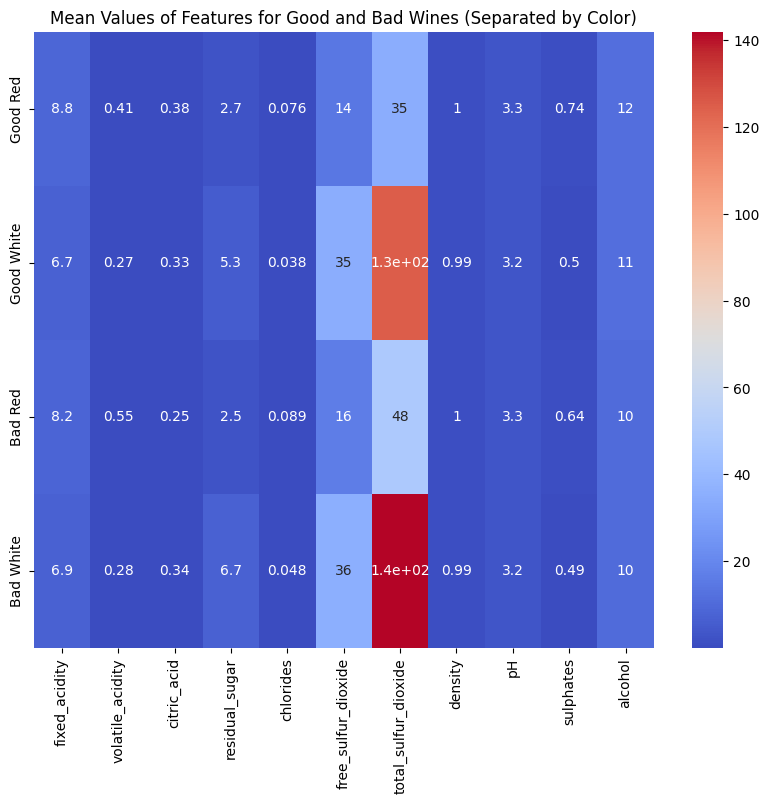

In [51]:
good_red = good_wines[good_wines["color"] == "red"]
good_white = good_wines[good_wines["color"] == "white"]

bad_red = bad_wines[bad_wines["color"] == "red"]
bad_white = bad_wines[bad_wines["color"] == "white"]

# Calculate mean values for each feature
good_red_means = good_red[features].mean()
good_white_means = good_white[features].mean()

bad_red_means = bad_red[features].mean()
bad_white_means = bad_white[features].mean()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.DataFrame(
        [good_red_means, good_white_means, bad_red_means, bad_white_means],
        index=["Good Red", "Good White", "Bad Red", "Bad White"],
    ),
    annot=True,
    cmap="coolwarm",
)
plt.title("Mean Values of Features for Good and Bad Wines (Separated by Color)")
plt.show()

By separating white and red wines, we saw that the total sulfur dioxide is different, for red wines it's not important, however for white a bigger value impact negatively

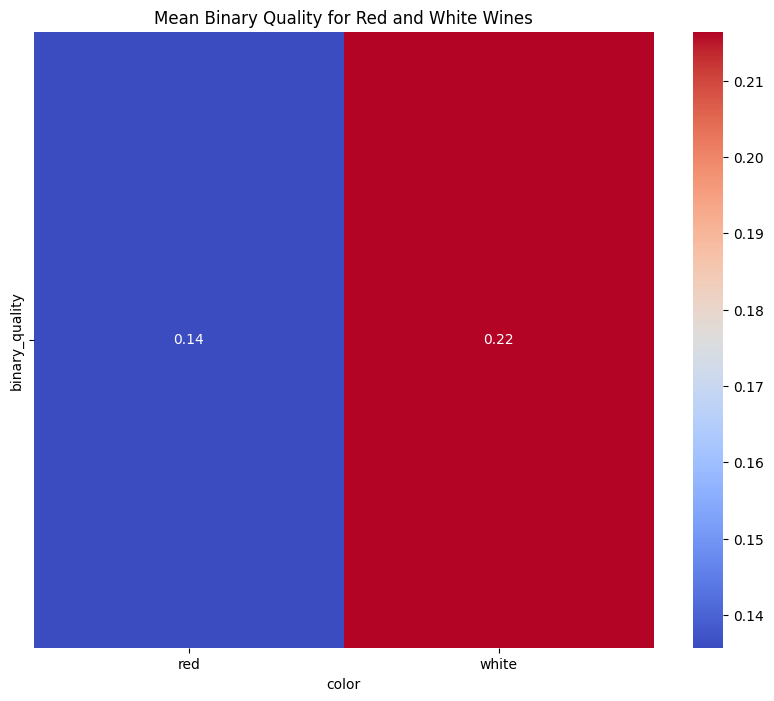

In [30]:
# Complete this cell with your code
plt.figure(figsize=(10, 8))
sns.heatmap(
    mean_binary_quality.to_frame().T,
    annot=True,
    cmap="coolwarm",
)
plt.title("Mean Binary Quality for Red and White Wines")
plt.show()

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [53]:
white_wine = wine_data[wine_data["color"] == "white"]

X = white_wine.drop(columns=["quality", "color", "binary_quality"])
# X["color"] = wine_data["color"].apply(lambda x: 1 if x == "red" else 0)
y = white_wine["binary_quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41
)

# display column name and data type for X_train an Y_train
print(X_train.dtypes)
print(y_train.dtypes)

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object
int64


In [54]:
# Complete this cell with your code

import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(random_state=42)

param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Best Score: 0.8542650585138271


In [60]:
y_pred = grid_search.best_estimator_.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred, average="weighted")

print(f"Training Accuracy Score: {accuracy}")
print(f"Training F1 Score: {f1}")

Accuracy Score: 0.9259826442062277
F1 Score: 0.9226054612047065


In [56]:
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Test Accuracy Score: {accuracy}")
print(f"Test F1 Score: {f1}")

Accuracy Score: 0.8571428571428571
F1 Score: 0.8484503085566916


- Analyze the results (test and train), validate whether there is overfitting.

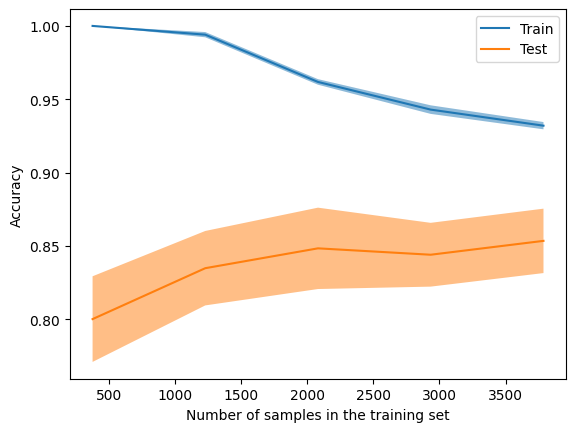

In [37]:
# Complete this cell with your code
LearningCurveDisplay.from_estimator(
    grid_search.best_estimator_, X_train, y_train, cv=30, scoring="accuracy"
)

- From the learningCurve, it's seems that the model is slighly overfitting, with an higher training score that test one

Text(70.72222222222221, 0.5, 'Actual')

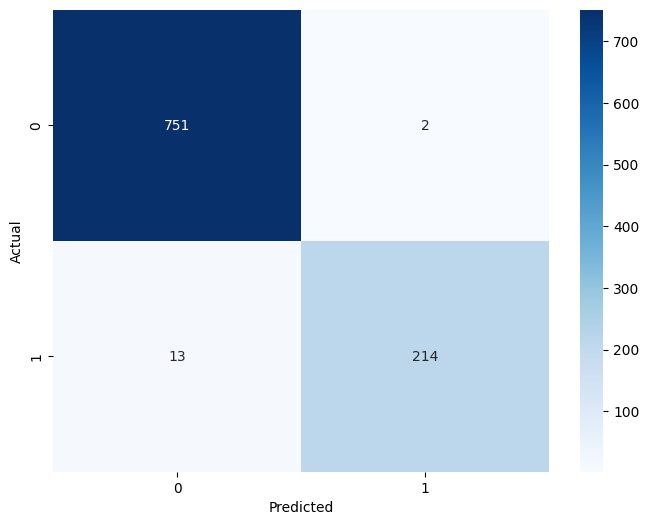

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

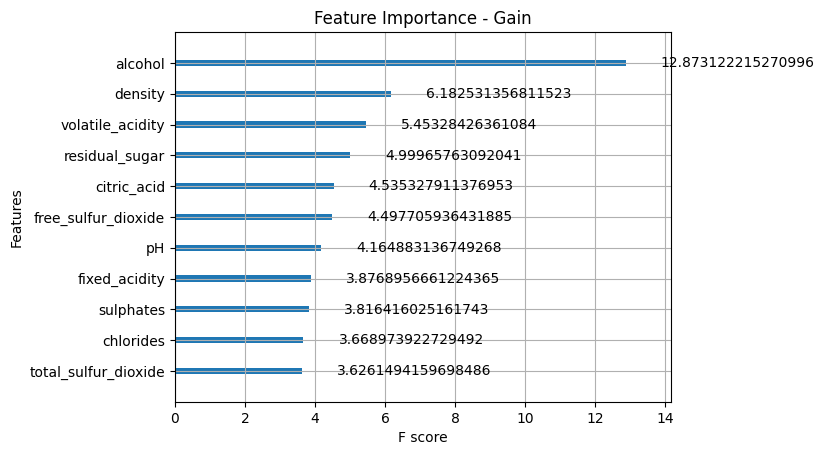

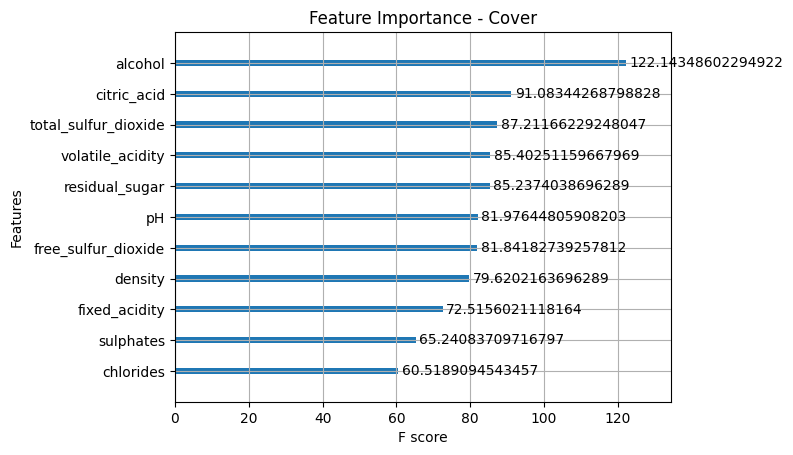

' # Interpretability with SHAP\nexplainer = shap.Explainer(grid_search.best_estimator_)\n\nshap_values = explainer.shap_values(X_train)\n\n# Plot the SHAP feature importance\nshap.summary_plot(shap_values, X_train, plot_type="bar")\n\n# SHAP summary plot to visualize feature importance across samples\nshap.summary_plot(shap_values, X_train) '

In [61]:
# Complete this cell with your code

xgb.plot_importance(grid_search.best_estimator_, importance_type="gain")
plt.title("Feature Importance - Gain")
plt.show()

# Plot feature importance based on 'cover'
xgb.plot_importance(grid_search.best_estimator_, importance_type="cover")
plt.title("Feature Importance - Cover")
plt.show()

""" # Interpretability with SHAP
explainer = shap.Explainer(grid_search.best_estimator_)

shap_values = explainer.shap_values(X_train)

# Plot the SHAP feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

# SHAP summary plot to visualize feature importance across samples
shap.summary_plot(shap_values, X_train) """

- The gain measures how much each feature contributes to improving the model decision quality.
    - The alcohol is the most important one, so it's mean that the model benefit a lot from it.
    - Density, volatile acidity and regular sugar contribut significantly less, but still have an impact.
    - In the other side, sulphates, chlorides and total sulfur dioxid doesn't help to improve the model compared to alcohol
- The cover measures the relative  quantity of observations that fall into splits made by a particular feature.
    - Alcohol also lead
    - Chlorides has the lowest score, so less frequently used in making splits during training

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

- In both Shap and XGBoost the alcohol remains the most important feature
- Volatile acidity, residual sugar, citric acide in both are similar importance, even if the ranking could slightly change.
- And chlorides, sulphates, fixed acidity remain to have little impact


    - Small differences can emerge for some features, however the variation is small

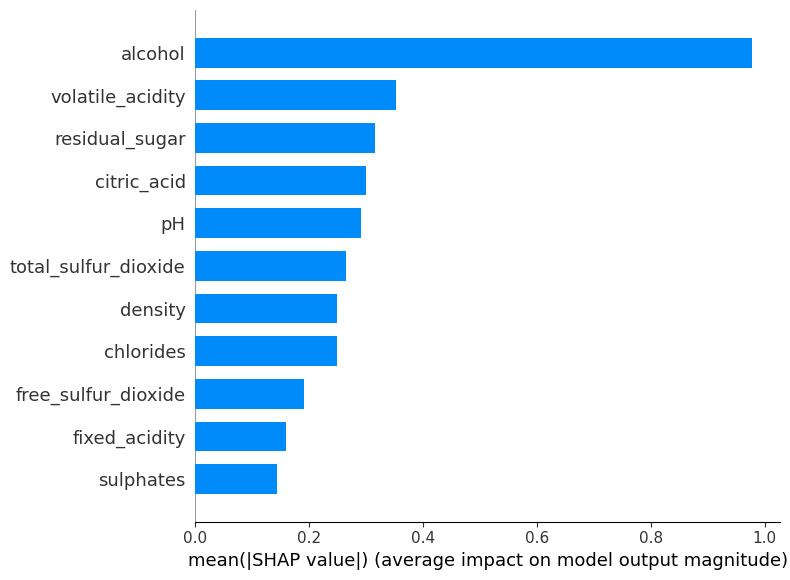

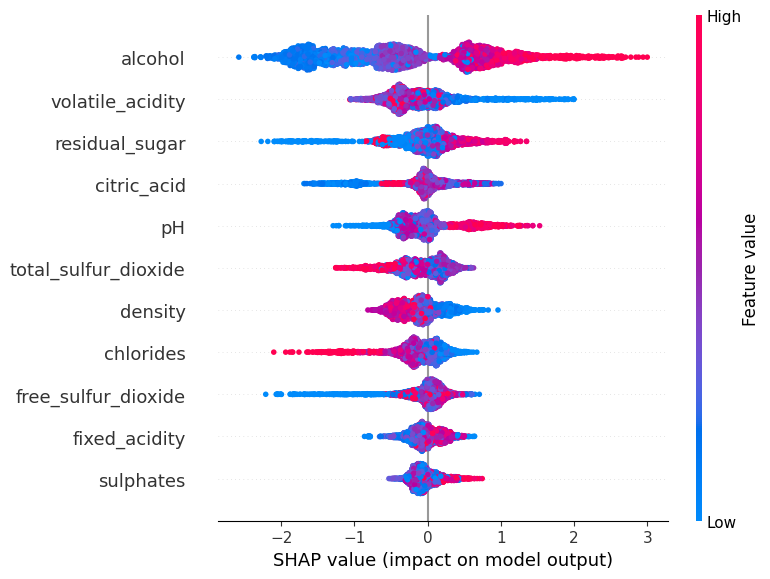

 98%|===================| 3828/3918 [00:25<00:00]        

In [40]:
# Complete this cell with your code
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

# Plot the SHAP bar summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Plot the SHAP beeswarm summary plot
shap.summary_plot(shap_values, X_train)


heat_explainer = shap.TreeExplainer(grid_search.best_estimator_, X_train)
heat_shap_values = heat_explainer(X_train)
# shap.plots.heatmap(heat_shap_values)

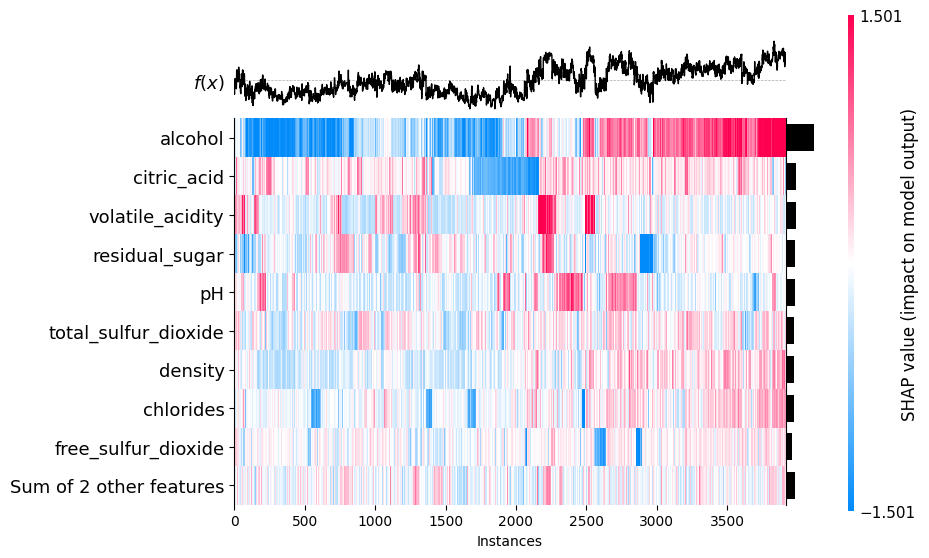

<Axes: xlabel='Instances'>

In [47]:
shap.plots.heatmap(heat_shap_values)

- We can really well see the impact of alcohol, the negative impact of cirtic acidity, the positive impact of volatile acidity, the residual sugar, a slight positive impact of pH and very slight negative impact of clorides and free sulfur dioxide on the heatmap

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

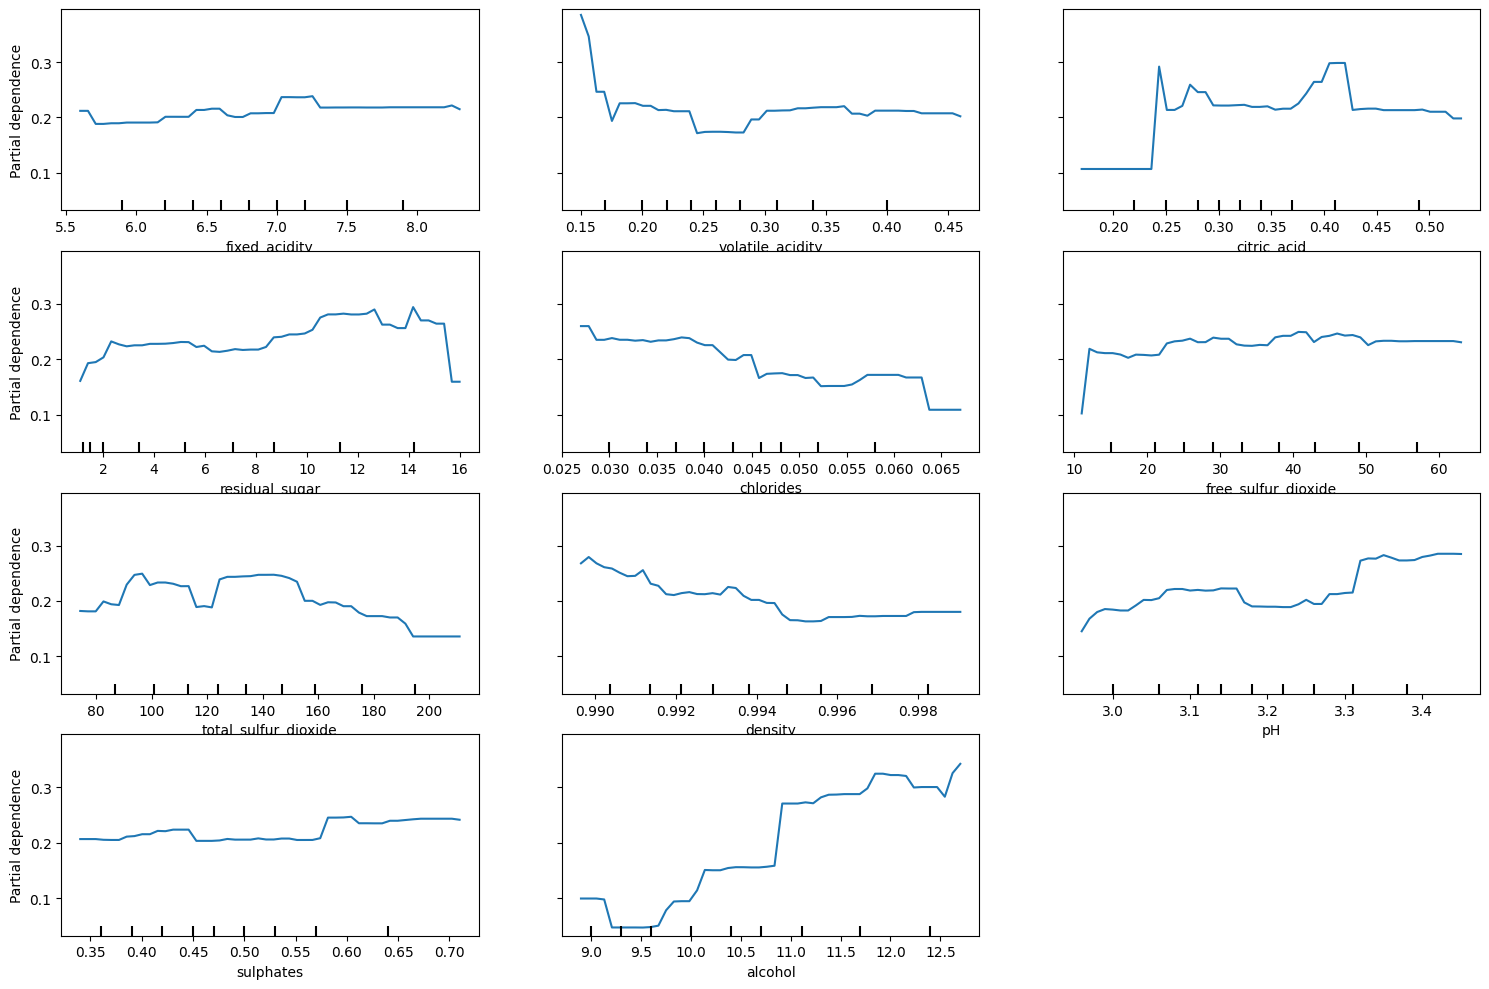

In [42]:
# Complete this cell with your code
features = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(
    grid_search.best_estimator_,
    X_train,
    features,
    ax=ax,
    grid_resolution=50,
    kind="average",
)
plt.tight_layout()
plt.show()

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

- Fixed Acidity
    - Fixed acids (primarily tartaric, malic, and to a lesser extent citric acid) contribute to the overall acidity of the wine, which affects the balance of flavor and stability during aging. Higher acidity tends to improve the crispness and freshness of the wine, especially in white wines.
- Volatile Acidity
    - Volatile acidity is mainly due to acetic acid, which gives an undesirable vinegar-like aroma if present in high amounts. This is a key indicator of spoilage. Acceptable levels of volatile acidity contribute to complexity, but higher levels are typically associated with poor quality and fermentation issues.
- Citric Acid
    - Citric acid is found in smaller amounts compared to tartaric and malic acids. It enhances the perceived freshness of the wine and contributes to acidity balance. It’s more commonly found as an additive rather than being naturally present in significant amounts.
- Residual Sugar
    - Residual sugar refers to the amount of sugar left after fermentation. This determines whether a wine is dry, off-dry, or sweet. In moderation, residual sugar balances acidity and can enhance flavors. Too much residual sugar, however, might signal incomplete fermentation or a low-quality wine aimed at masking other flaws.
- Chlorides
    - Chlorides contribute to the saltiness in wine, and their presence at higher levels can affect taste negatively, giving the wine an off-putting saline characteristic. It’s often linked to the vineyard's soil and winemaking water source.
- Free Sulfur Dioxide and Total Sulfur Dioxide
    - Sulfur dioxide (SO₂) acts as an antioxidant and antimicrobial agent. It prevents oxidation and microbial growth during winemaking, thus contributing to the stability and shelf life of wine. However, excessive SO₂ can lead to negative sensory perceptions like unpleasant aromas.
        - Free SO₂: This is the portion of sulfur dioxide that is not bound and is available to protect the wine from microbial growth and oxidation.
        - Total SO₂: The sum of both bound and free sulfur dioxide in the wine. Regulations dictate maximum allowable levels since too much SO₂ can impact both the flavor and health perception of the wine.
- Density
    - The density of wine is closely related to the sugar and alcohol content. High density usually indicates higher sugar levels (i.e., sweet wine), while lower density can indicate a dry wine. This is a key parameter for determining the progress and completeness of fermentation.
- pH
    - The pH of wine is an indicator of its acidity but on a logarithmic scale, which also affects microbial stability. Lower pH wines (more acidic) are generally more stable and have a fresh, bright taste, which is preferable in most white wines. The pH also influences the wine's color and aging potential.
- Sulphates
    - Sulphates in wine primarily relate to potassium bisulfate, which contributes to taste, helping to stabilize the wine. It affects the perceived body and mouthfeel of the wine and contributes to the balance of acidity.
- Alcohol
    - Alcohol is a major contributor to the body of the wine and has a warming effect on the palate. Alcohol levels also significantly influence the perceived sweetness and overall balance. Generally, higher alcohol wines have more body, but too much alcohol can result in a “hot” taste, reducing drinkability.


- Connection with Wine quality :
    - Acidity, pH, and alcohol need to be balanced to create a harmonious and enjoyable wine.
    - Residual sugar and alcohol can balance each other—too much sugar without enough acidity makes the wine taste cloying.
    - Sulphates and sulfur dioxide levels are critical for maintaining wine quality during bottling and storage.

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

 97%|=================== | 3793/3918 [00:24<00:00]       

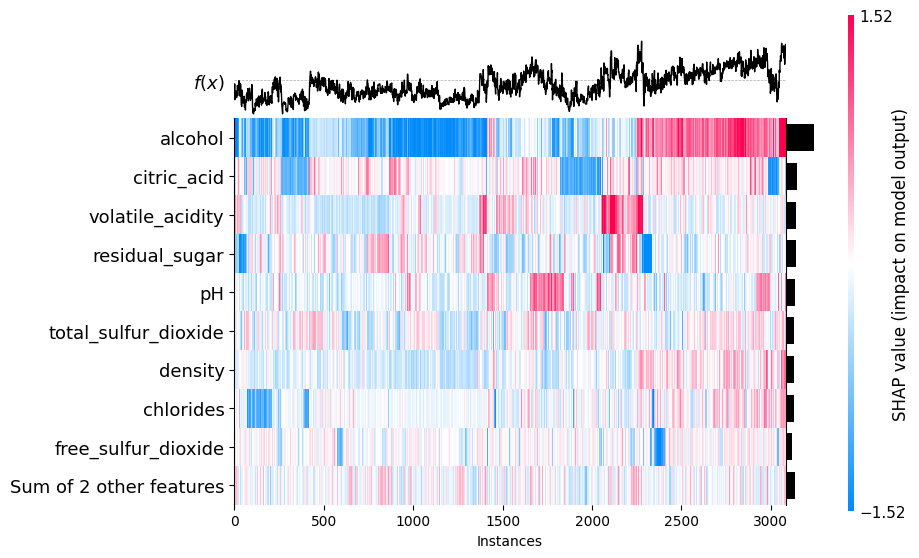

<Axes: xlabel='Instances'>

In [45]:
# Complete this cell with your code
explainer = shap.TreeExplainer(grid_search.best_estimator_, X_train)
shap_values = explainer(X_train)

# sort the bad wines by the shap values
bad_wines = X_train[y_train == 0]

shap_values_bad = shap_values[y_train.values == 0]

shap_values_bad_sum = np.sum(np.abs(shap_values_bad.values), axis=1)

sorted_idx = np.argsort(shap_values_bad_sum)

bad_wines_sorted = bad_wines.iloc[sorted_idx]



# heatmao
shap.plots.heatmap(shap_values_bad)

In [46]:
bad_wines_sorted

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
4335,6.5,0.170,0.31,1.5,0.041,34.0,121.0,0.99092,3.06,0.46,10.5
1898,6.7,0.170,0.50,2.1,0.043,27.0,122.0,0.99230,3.15,0.45,10.3
2496,7.0,0.290,0.26,1.6,0.044,12.0,87.0,0.99230,3.08,0.46,10.5
5568,6.4,0.170,0.30,2.8,0.034,33.0,125.0,0.99152,3.03,0.49,10.4
5570,6.4,0.170,0.30,2.8,0.034,33.0,125.0,0.99152,3.03,0.49,10.4
...,...,...,...,...,...,...,...,...,...,...,...
4555,8.1,0.120,0.38,0.9,0.034,36.0,86.0,0.99026,2.80,0.55,12.0
6159,5.4,0.270,0.22,4.6,0.022,29.0,107.0,0.98889,3.33,0.54,13.8
4814,7.1,0.140,0.33,1.0,0.104,20.0,54.0,0.99057,3.19,0.64,11.5
2965,7.0,0.140,0.41,0.9,0.037,22.0,95.0,0.99140,3.25,0.43,10.9


# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.